In [ ]:
import sys
sys.path.append("/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal")

#from graphseq_inference.data_utils import *
#from graphseq_inference.train_utils import *

from GNNcoal.models import *

import matplotlib.pyplot as plt
import msprime
import numpy as np
from pathlib import Path
import random
import tskit
import pandas as pd

%load_ext autoreload
%autoreload 2

In [ ]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Loading the trained model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

<All keys matched successfully>

In [ ]:
def get_population_time(time_rate:float=0.06, tmax:int = 130_000,
                        num_time_windows:int = 21
                       ) -> np.array :
    """Creates population time points; used as time points to change
    population size changes for simulation
    
    :return numpy.ndarray: time points of length num_time_windows
    """

    population_time = np.repeat([(np.exp(np.log(1 + time_rate * tmax) * i /
                              (num_time_windows - 1)) - 1) / time_rate for i in
                              range(num_time_windows)], 1, axis=0)
    population_time[0] = 1
    return population_time


def sample_population_size(n_min:int=10, n_max:int=100_000, num_time_windows=21) -> list[float]:

    """Creates random demography. Function taken from: 
    https://gitlab.inria.fr/ml_genetics/public/dlpopsize_paper
    
    :param int n_min: Lower-bound of demography.
    :param int n_max: Upper-bound of demography.
    :param int num_time_windows: Number of population sizes in demography.
    :return list: 
    """

    n_min_log10 = np.log10(n_min)
    n_max_log10 = np.log10(n_max)
    population_size = [10 ** np.random.uniform(low=n_min_log10, high=n_max_log10)]
    for j in range(num_time_windows - 1):
        population_size.append(10 ** n_min_log10 - 1)
        while population_size[-1] > 10 ** n_max_log10 or population_size[-1]  < 10 ** n_min_log10:
            population_size[-1] = population_size[-2] * 10 ** np.random.uniform(-1, 1)

    return population_size


def get_random_time_and_demography():
    from scipy.interpolate import interp1d
    upper_out_of_bound = lower_out_of_bound = True
    while upper_out_of_bound or lower_out_of_bound:
        steps = 18
        x = np.log(get_population_time(time_rate=0.1, num_time_windows=steps, tmax=10_000_000).tolist())
        y = np.log(sample_population_size(10_000, 10_000_000, steps))
        xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
        f_cubic = interp1d(x, y, kind='cubic')
        ynew = f_cubic(xnew)
        upper_out_of_bound = np.sum(np.exp(ynew) > 10_000_000) > 0
        lower_out_of_bound = np.sum(np.exp(ynew) < 10_000) > 0
    x_sample = xnew[np.linspace(10, 9999, 60).astype(int)]
    y_sample = ynew[np.linspace(10, 9999, 60).astype(int)]
    demography = np.exp(y_sample)
    population_time = np.exp(x_sample)
    return population_time, demography

population_time, demography = get_random_time_and_demography()
#sns.lineplot(x=population_time, y=demography)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(1000, 100_000_000)
#plt.xlim(10,10_000_000)

In [ ]:
def get_train_test_dataset(data:str = "../dataset/", split:float = 0.9):

    file_names = os.listdir(data)#[0:1000]
    file_names = sorted(file_names)
    file_names = [data + file for file in file_names]
    train_split = int(len(file_names) * split)
    train_filenames = file_names[:train_split]
    test_filenames = file_names[train_split:]
    train_dataset = MyDataset(train_filenames)
    test_dataset = MyDataset(test_filenames)
    
    return train_dataset, test_dataset

## Converting a tree sequence to data object used for training and inference

In [ ]:
def convert_tree_sequence_to_data_object(tree_sequence: tskit.trees.TreeSequence,
                                                     parameters: np.ndarray,
                                                     num_trees:int = 500,
                                                     num_embedding:int = 60, 
                           ):
    
    population_size = parameters["pop_size_0":"pop_size_59"].tolist() 
    y = torch.Tensor(population_size)
    
    max_num_nodes = 2 * tree_sequence.num_samples - 1 
    data_objects = []
    
    for i, tree in enumerate(tree_sequence.trees()):
        if i < num_trees:
            
            data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
            rename_data_attribute(data, "branch_length", "edge_weight") 
            num_nodes = data.num_nodes
            data.x = torch.eye(max_num_nodes,num_embedding)
            data.x[num_nodes:] = torch.zeros(num_embedding)
            data.y = torch.Tensor(torch.log(y))
            data.num_nodes = max_num_nodes
            data_objects.append(data)
            
        else: 
            break

        
    return data_objects

In [ ]:
def reshape_y_true(y_true, batch_size:int=500, n_out=60, to_device: bool =True):
    """ Reshaping of y_true variable to (batch_size, n_out)
    """
    if to_device: y_true = y_true.tile(batch_size).reshape(batch_size, n_out).to(device)
    else: y_true = y_true.tile(len(data_objects)).reshape(batch_size, n_out)
    return y_true

def pass_one_data_point(data_point):
    with torch.no_grad():
        data_objects, mask = data_point
        mask = np.tile(mask, len(data_objects)).reshape(len(data_objects), 60)
        dl = DataLoader(data_objects, batch_size=len(data_objects))
        batch = next(iter(dl))
        batch = batch.to(device)
        y_hat = model(batch)
        y_true = reshape_y_true(data_objects[0].y, len(data_objects))
    return y_true, y_hat, mask

def prepare_for_plotting(y_true, y_hat, mask, population_time):
    y_true_unmasked = deepcopy(y_true)
    y_hat_unmasked = deepcopy(y_hat)
    y_true[~mask] = 0
    y_hat[~mask] = 0
    y_true = y_true.cpu().numpy().mean(0)
    y_hat = y_hat.cpu().numpy().mean(0)
    y_true_unmasked = y_true_unmasked.cpu().numpy().mean(0)
    y_hat_unmasked = y_hat_unmasked.cpu().numpy().mean(0)
    adapted_population_time = population_time[y_hat != 0]
    y_hat = y_hat[y_hat != 0]
    return y_true, y_true_unmasked, y_hat_unmasked, y_hat, adapted_population_time


def plot_demography():
    sns.set(style="ticks", font_scale=1.2)
    fig, axs = plt.subplots(1, 1, figsize=(8,4), sharex=True, sharey=True)
    sns.lineplot(x=population_time,y=np.exp(y_true_unmasked),drawstyle='steps-mid', color="lightgrey", alpha=0.75, ax=axs)
    sns.lineplot(x=adapted_population_time, y=np.exp(y_hat), drawstyle='steps-mid', color="darkblue", alpha=0.75, ax=axs)
    sns.lineplot(x=population_time,y=np.exp(y_true_unmasked), color="lightgrey", alpha=0.75, ax=axs)
    sns.lineplot(x=adapted_population_time, y=np.exp(y_hat), color="darkblue", alpha=0.75, ax=axs)
    axs.set(xlabel="time [generations]", ylabel="population size [Ne]")
    plt.axvline(x=10, color='k', linestyle='--')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1000, 100_000_000)
    plt.xlim(None,10_000_000)
    
def plot_demography_with_error():
    sns.set(style="ticks", font_scale=1.2)
    fig, axs = plt.subplots(1, 1, figsize=(8,4), sharex=True, sharey=True)
    
    sns.lineplot(x=population_time,y=np.exp(y_true_unmasked), color="lightgrey", alpha=0.75, ax=axs)
    sns.lineplot(data=y_hats, x="adapted_population_time", y="population_size", color="darkblue", alpha=0.75, ax=axs)
    
    axs.set(xlabel="time [generations]", ylabel="population size [Ne]")
    plt.axvline(x=10, color='k', linestyle='--')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1000, 100_000_000)
    plt.xlim(None,10_000_000)

In [ ]:
from sklearn.linear_model import LinearRegression

"""
def get_sequence_length(alpha):
    X = np.array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]).reshape(-1, 1)
    y = np.array([903272667.6483952, 449680355.2510645,178743721.59285852, 70857015.72050871,26609043.76117958,
                  10475248.838195799,4518011.131732858, 2024414.914914666, 1265514.8452846785])
    y = y * 2
    y = np.log(y)
    reg = LinearRegression().fit(X, y)
    if alpha >= 1.75:
        alpha = 1.75
    sequence_length = int(np.exp(reg.predict(np.array([[alpha]])).item()))
    return sequence_length
"""



'\ndef get_sequence_length(alpha):\n    X = np.array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]).reshape(-1, 1)\n    y = np.array([903272667.6483952, 449680355.2510645,178743721.59285852, 70857015.72050871,26609043.76117958,\n                  10475248.838195799,4518011.131732858, 2024414.914914666, 1265514.8452846785])\n    y = y * 2\n    y = np.log(y)\n    reg = LinearRegression().fit(X, y)\n    if alpha >= 1.75:\n        alpha = 1.75\n    sequence_length = int(np.exp(reg.predict(np.array([[alpha]])).item()))\n    return sequence_length\n'

In [ ]:
def alternative_coalescent_mask(ts, population_time, x_times_std=2, n_trees=500):
    
    trees = ts.aslist()[0:n_trees]
    nodes_n_trees = []
    for tree in trees:
        nodes_n_trees += list(tree.nodes())
    
    node_times = [ts.get_time(node.id) for node in ts.nodes() if node.id >= ts.num_samples and node.id in nodes_n_trees]
    
    log_node_times = np.log(node_times)
    mean = log_node_times.mean()
    std = log_node_times.std()
    lowerbound = np.exp(mean-x_times_std*std)
    upperbound = np.exp(mean+x_times_std*std)
    mask1 = population_time > lowerbound
    mask2 = population_time < upperbound
    mask = np.logical_and(mask1, mask2)
    return mask


def alternative_mask(tree_sequences, population_time, x_times_std=3):
    masks = []
    for i, ts in enumerate(tree_sequences):
        mask = alternative_coalescent_mask(ts, population_time, x_times_std)
        masks.append(mask)
    mask = np.array(masks)
    mask = mask.sum(0) >= 2
    return mask


def get_xy_variable(dataset):
    
    y_hats = []
    adapted_population_times = []
    original_yhats = []
    original_population_times = []
    
    for i in range(0,10):
        try:
            data_objects, mask = dataset[i]
            mask = mask[0]
            mask[population_time <= 10] = False  
            y_true, y_hat, mask = pass_one_data_point((data_objects, mask))   
            y_true, y_true_unmasked, y_hat_unmasked, y_hat, adapted_population_time = prepare_for_plotting(y_true, y_hat, mask, population_time)               
            y_hats += np.exp(y_hat).tolist()
            adapted_population_times += adapted_population_time.tolist()
            original_yhats += np.exp(y_hat_unmasked).tolist()
            original_population_times += population_time.tolist()
            
        except Exception as e:
            print(e)
            
    return adapted_population_times, y_hats, original_population_times, original_yhats


#def reduce_tree_sequence(ts, num_samples):
#    return ts.simplify(np.random.choice(range(ts.num_samples),
#                                 num_samples, replace=False).tolist())

def reduce_tree_sequence(ts, num_samples):
    return ts.simplify(np.random.choice(range(ts.num_samples),
                                 num_samples, replace=False).tolist())

def reduce_tree_sequence(ts, num_samples):
    return ts.simplify([1,5,9])


def create_dataset(tree_sequences, demography, directory, reduce=False, start_tree=0, all_trees=False):
    for i, ts in enumerate(tqdm(tree_sequences)):
        if reduce:
            ts = reduce_tree_sequence(ts, 3)
        mask = alternative_coalescent_mask(ts, population_time, x_times_std=2)
        mask = np.tile(mask, 100).reshape(100, 60)
        convert_ts_to_do(ts, demography, mask, directory=directory, replicate=i, start_tree=start_tree, all_trees=all_trees)

def convert_ts_to_do(tree_sequence: tskit.trees.TreeSequence,
                                                     demography: np.ndarray,
                                                     mask: np.ndarray,
                                                     num_trees:int = 500,
                                                     num_embedding:int = 60, 
                                                     directory: str = "datasets",
                                                     replicate: int = 0,
                                                     start_tree=0,
                                                     all_trees=False,
                                                    
                     
                           ):
    """ Converts tree_sequence to a data_object.
    
    
    Arg types:
        * **tree_sequence** *(tree sequence)* - A single tree sequence
        * **parameter** *(numpy array)* - Parameter for simulation.
        * **mask** *(tree sequence)* - A single tree sequence
        * **num_trees** *(int)* - Number of trees used for discretization.
        * **num_embedding** *(int)* - emdbedding.
    
    """
    
    if not os.path.exists(directory): os.makedirs(directory)
    
    y = torch.Tensor(demography.tolist())
    if all_trees:
        trees = tree_sequence.aslist()
    else:
         trees = tree_sequence.aslist()[start_tree:start_tree+num_trees]
            
    data_objects = datatize_trees(trees)

    max_num_nodes = 2 * tree_sequence.num_samples - 1 
    for _ , data in enumerate(data_objects):
        num_nodes = data.num_nodes
        data.x = torch.eye(max_num_nodes,num_embedding)
        data.x[num_nodes:] = torch.zeros(num_embedding)
        data.y = torch.Tensor(torch.log(y))
        data.num_nodes = max_num_nodes

    torch.save((data_objects, mask), open("./" + str(directory) + "/data_" + str(replicate) + ".pth", "wb"))

### Simulating scenarios for validation

In [ ]:
"""
def sawtooth_demography(alpha, num_replicates=100):
    
    sample_size=10
    mu=1e-8
    r=1e-8
    Ne=10**6
    L = get_sequence_length(alpha)
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 
"""

def sawtooth(alpha, replicates=10, Ne = 10**6):
    sample_size = 10
    #L = 10**8
    L = get_sequence_length(alpha)
    r = 1e-8
    
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,replicates+1):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

def sawtooth_noseed(alpha, sequence_length=100_000, replicates=10):
    sample_size = 10
    #L = 10**8
    L = sequence_length
    r = 1e-8
    Ne = 10**6
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,replicates+1):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 



def bottleneck(alpha, Ne = 10**6):
    sample_size = 10
    #L = 10**8
    L = get_sequence_length(alpha)
    r = 1e-8
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne/10)
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

def bottleneck_noseed(alpha, sequence_length=100_000, replicates=10):
    sample_size = 10
    #L = 10**8
    L = sequence_length
    r = 1e-8
    Ne = 10**6
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne/10)
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,replicates+1):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 




def decrease(alpha, Ne = 10**6):
    sample_size = 10
    #L = 10**8
    L = get_sequence_length(alpha)
    r = 1e-8
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne/10))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def decrease2(alpha):
    sample_size = 10
    #L = 10**8
    L = get_sequence_length(alpha)
    r = 1e-8
    Ne = 10**6
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne/10))
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def decrease3(alpha):
    sample_size = 10
    #L = 10**8
    L = get_sequence_length(alpha)
    r = 1e-8
    Ne = 10**6
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne/10))
    demography.add_population_parameters_change(time=10000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def bottleneck_demography2(alpha, num_replicates=10):
    
    sample_size=10
    mu=1e-8
    r=1e-8
    Ne=10**6
    L = get_sequence_length(alpha)
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne/10)
    demography.add_population_parameters_change(time=10000, growth_rate=0, initial_size=Ne)

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates, random_seed=((alpha*x+1)**2))
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 




def constant(alpha, num_replicates=10, Ne = 10**6):
    
    sample_size=10
    mu=1e-8
    r=1e-8
    L = get_sequence_length(alpha)
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 



def constant2(alpha, num_replicates=10):
    
    sample_size=10
    mu=1e-8
    r=1e-8
    Ne= 10**5
    L = get_sequence_length(alpha)
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = msprime.sim_ancestry(samples=10,
                                          recombination_rate=r, sequence_length=L, demography=demography,
                                          ploidy=1,model=msprime.BetaCoalescent(alpha=alpha),
                                          num_replicates=num_replicates, random_seed=((alpha*x+1)**2))
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 




def increase(alpha, num_replicates=10, Ne = 10**6):
    
    sample_size=10
    mu=1e-8
    r=1e-8
    L = get_sequence_length(alpha)
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne*10))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne)

    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    
    return list(tree_sequences), demography 




        
        
        
def kingman_sawtooth(Ne = 10**6):
    sample_size = 10
    #L = 10**8
    L = 100_000
    r = 1e-8
    
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 
        
    
def kingman_sawtooth(Ne=10**4, L=10_000_000):
    sample_size = 10
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 





def kingman_constant(Ne=10**4, L=10_000_000):
    sample_size = 10
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 



def kingman_increase(Ne=10**4, L=10_000_000):
    sample_size = 10
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne*10))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def kingman_decrease(Ne=10**4, L=10_000_000):
    sample_size = 10
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne/10))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def kingman_bottleneck(Ne=10**4, L=10_000_000):
    sample_size = 10
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=100, growth_rate=0, initial_size=Ne/10)
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)

    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

In [ ]:
def simul_scenario():
    sample_size=10
    mu=1*1e-8
    tss = []
    for L in [10**6]:#
        for r in [1]:
            r=mu*r
            for s in [0]:#,0.001,0.0001,0.00001
                Ne=10**5
                demography=msprime.Demography()
                demography.add_population(initial_size=(Ne))
                #demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
                #demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
                #demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
                #demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
                demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
                demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
                db = msprime.DemographyDebugger(demography=demography)
                for x in range(1,11):
                    #ts=msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
                    #ts.print_history()
                    if s == 0:
                        ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,sequence_length=L,demography=demography,ploidy=1 ,model=[msprime.StandardCoalescent()],random_seed=((x+3)**2)) 
                    
                    tss.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tss), demography 




def simul_scenario():
    sample_size=10
    mu=1*1e-8
    tss = []
    for L in [10**6]:#
        for r in [1]:
            r=mu*r
            for s in [0]:#,0.001,0.0001,0.00001
                Ne=10**5
                demography=msprime.Demography()
                demography.add_population(initial_size=(Ne))
                #demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
                #demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
                #demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
                #demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
                demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
                demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
                db = msprime.DemographyDebugger(demography=demography)
                for x in range(1,11):
                    #ts=msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
                    #ts.print_history()
                    if s == 0:
                        ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,sequence_length=L,demography=demography,ploidy=1 ,model=[msprime.StandardCoalescent()],random_seed=((x+3)**2)) 
                    
                    tss.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tss), demography 


def simul_selection_scenario():
    sample_size=10
    mu=1*1e-8
    tss = []
    for L in [10**6]:#
        for r in [1]:
            r=mu*r
            for s in [0.01]:#,0.01,0.0001,0.00001
                Ne=10**5
                demography=msprime.Demography()
                demography.add_population(initial_size=(Ne))
                #demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
                #demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
                #demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
                #demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
                demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
                demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
                demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
                demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
                db = msprime.DemographyDebugger(demography=demography)

                for x in range(1,11):
                    #ts=msprime.DemographyDebugger(demography=demography,model=[msprime.SweepGenicSelection(position=(L/2),start_frequency=(1/(Ne)),end_frequency=(1 - 1/ Ne),s=s,dt=(1/(100*Ne))),msprime.StandardCoalescent()])
                    #ts.print_history()

                    ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,sequence_length=L,demography=demography,ploidy=1 ,model=[msprime.SweepGenicSelection(position=(L/2),start_frequency=(1/(Ne)),end_frequency=(1 - 1/ Ne),s=s,dt=(1/(100*Ne))),msprime.StandardCoalescent()],random_seed=((x+3)**2))

                    tss.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tss), demography 

In [ ]:
def plot_estimation(ax, times, sizes, population_time, demography, title=None, color="darkblue"):
    sns.lineplot(x=times, y=sizes, drawstyle='steps-mid', color=color, alpha=0.75, ax=ax).set_title(title)
    sns.lineplot(x=population_time, y=demography, color="black", alpha=0.75, ax=ax).set_title(title)
    ax.set(xlabel="time [generations]", ylabel="population size [Ne]")
    

In [ ]:
def run_evaluation(demography_name, tree_sequence_function):

    tree_sequences, demography  = tree_sequence_function(alpha=1.9)
    create_dataset(tree_sequences, demography, demography_name)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times19, sizes19, unmasked_times19, unmasked_sizes19 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.7)
    create_dataset(tree_sequences, demography, demography_name)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times17, sizes17, unmasked_times17, unmasked_sizes17 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.5)
    create_dataset(tree_sequences, demography, demography_name)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times15, sizes15, unmasked_times15, unmasked_sizes15 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.3)
    create_dataset(tree_sequences, demography, demography_name)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times13, sizes13, unmasked_times13, unmasked_sizes13 = get_xy_variable(dataset)
    
    return times19, sizes19, unmasked_times19, unmasked_sizes19, times17, sizes17, unmasked_times17, unmasked_sizes17, times15, sizes15, unmasked_times15, unmasked_sizes15, times13, sizes13, unmasked_times13, unmasked_sizes13, demography
        

In [ ]:
def remove_first_segment(df):
    new_popsizes = []
    for r in range(10):
        replicate = df[df["replicates"] == r]
        replicate_popsizes = []
        prev_popsize = replicate["population_size"].iloc[0]
        
        first_segment = True
        
        if replicate["population_size"].iloc[0] == replicate["population_size"].iloc[1]:
            replicate_popsizes.append(0)
        else:
            replicate_popsizes.append(replicate["population_size"][0])
            first_segment = False

        
        for i, row in replicate.iterrows():
            if i != 0:
                if prev_popsize == replicate["population_size"][i] and first_segment:
                    replicate_popsizes.append(replicate["population_size"][i])
                else:
                    replicate_popsizes.append(replicate["population_size"][i])
                    first_segment = False

        new_popsizes.append(replicate_popsizes)
    df["population_size"] = pd.DataFrame(new_popsizes).melt()["value"]
    df = df[df["population_size"] != 0]
    return df

def remove_low_prediction(ut, us, threshold=100):
    us = [0 if prediction < 100 else prediction for prediction in us]
    temp_mask = np.array(us) != 0
    ut = (np.array(ut)[temp_mask]).tolist()
    us = (np.array(us)[temp_mask]).tolist()
    return ut, us

def smbc_to_plotable_df(x,y, rolling_mean=10):
    x = pd.read_csv(x).iloc[:,1:]
    y = pd.read_csv(y).iloc[:,1:]
    assert x.shape == (10, 40)
    assert y.shape == (10, 40)
    time = x.melt()["value"]
    population_size = y.melt()["value"]
    df = pd.DataFrame([time, population_size]).T
    df.columns = ["time", "population_size"]
    
    df["replicates"] = np.tile(range(10), 40)
    df = remove_first_segment(df)
    
    #df["time_rm"] = df["time"].rolling(rolling_mean).mean()
    #df["population_size_rm"] = df["population_size"].rolling(rolling_mean).mean()
    
    df["time_rm"] = df["time"].rolling(rolling_mean).median()
    df["population_size_rm"] = df["population_size"].rolling(rolling_mean).median()
    
    df["population_size_rstd"] = df["population_size"].rolling(rolling_mean).std()
    
    return df

def plot_smbc_df(df, ax, title=None, plt_avg=True):
    sns.lineplot(data=df, x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.2, legend=False, ax=ax)
    if plt_avg: sns.lineplot(data=df, x="time_rm", y="population_size_rm", drawstyle='steps-mid', legend=False, color="red", ax=ax).set(title=title)
   


In [ ]:
num_sample = "M3"
scenario = "Sawtooth"
alphas = ["1.9", "1.7", "1.5", "1.3"]

In [ ]:
def alternative_mask(tree_sequences, population_time, x_times_std=3):
    masks = []
    for i, ts in enumerate(tree_sequences):
        mask = alternative_coalescent_mask(ts, population_time, x_times_std)
        masks.append(mask)
    mask = np.array(masks)
    mask = mask.sum(0) >= 2
    return mask

# Figure 1

In [ ]:
def smbc_to_plotable_df2(x,y, rolling_mean=10, msmc_idx=0, start_row=0):
    x = pd.read_csv(x).iloc[:,1:]
    y = pd.read_csv(y).iloc[:,1:]
    
    x = x.iloc[start_row:start_row+20]
    y = y.iloc[start_row:start_row+20]
    
    y = 10**y

    x = x.iloc[msmc_idx::2,:]
    y = y.iloc[msmc_idx::2,:]
    
    assert x.shape == (10, 40)
    assert y.shape == (10, 40)
    
    time = x.melt()["value"]
    population_size = y.melt()["value"]
    df = pd.DataFrame([time, population_size]).T
    df.columns = ["time", "population_size"]
    
    
    df["replicates"] = np.tile(range(10), 40)
    
    df = remove_first_segment(df)
    #df["time_rm"] = df["time"].rolling(rolling_mean).mean()    
    #df["population_size_rm"] = df["population_size"].rolling(rolling_mean).mean()
    
    df["time_rm"] = df["time"].rolling(rolling_mean).median()    
    df["population_size_rm"] = df["population_size"].rolling(rolling_mean).median()
    
    df["population_size_rstd"] = df["population_size"].rolling(rolling_mean).std()
    return df


In [ ]:
_, demography  = kingman_sawtooth(Ne=10**6, L=1)

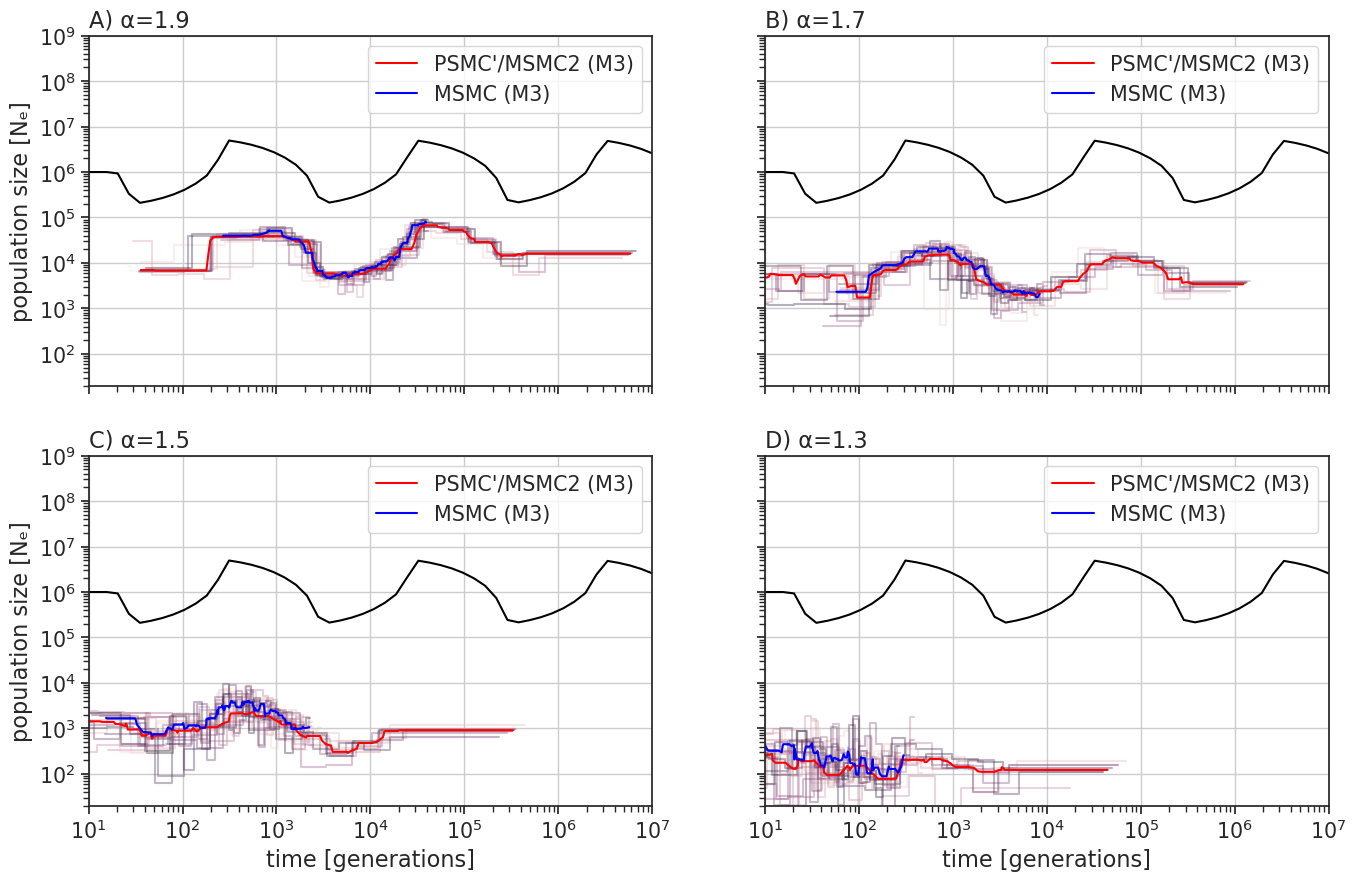

In [ ]:
sns.set(font_scale=1.35)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(16,10), sharex=True, sharey=True)

alphat = 0.35

x = "data/psmc_msmc/Fig_1_test_beta_mat_save_t_real_not_corrected__theta_4e+06_rho_1_.csv"
y = "data/psmc_msmc/Fig_1_test_beta_mat_save_p_real_not_corrected__theta_4e+06_rho_1_.csv"

df0 = smbc_to_plotable_df2(x=x, y=y)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[0][0]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("A) α=1.9", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)



df0 = smbc_to_plotable_df2(x=x, y=y, start_row=20)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=20)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[0][1]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("B) α=1.7", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)


df0 = smbc_to_plotable_df2(x=x, y=y, start_row=40)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=40)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[1][0]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("C) α=1.5", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)



df0 = smbc_to_plotable_df2(x=x, y=y, start_row=60)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=60)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[1][1]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("D) α=1.3", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)




plt.yscale('log')
plt.xscale('log')
plt.ylim(20, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/figure_1_fix.pdf", dpi=600)

# Subfigure 1

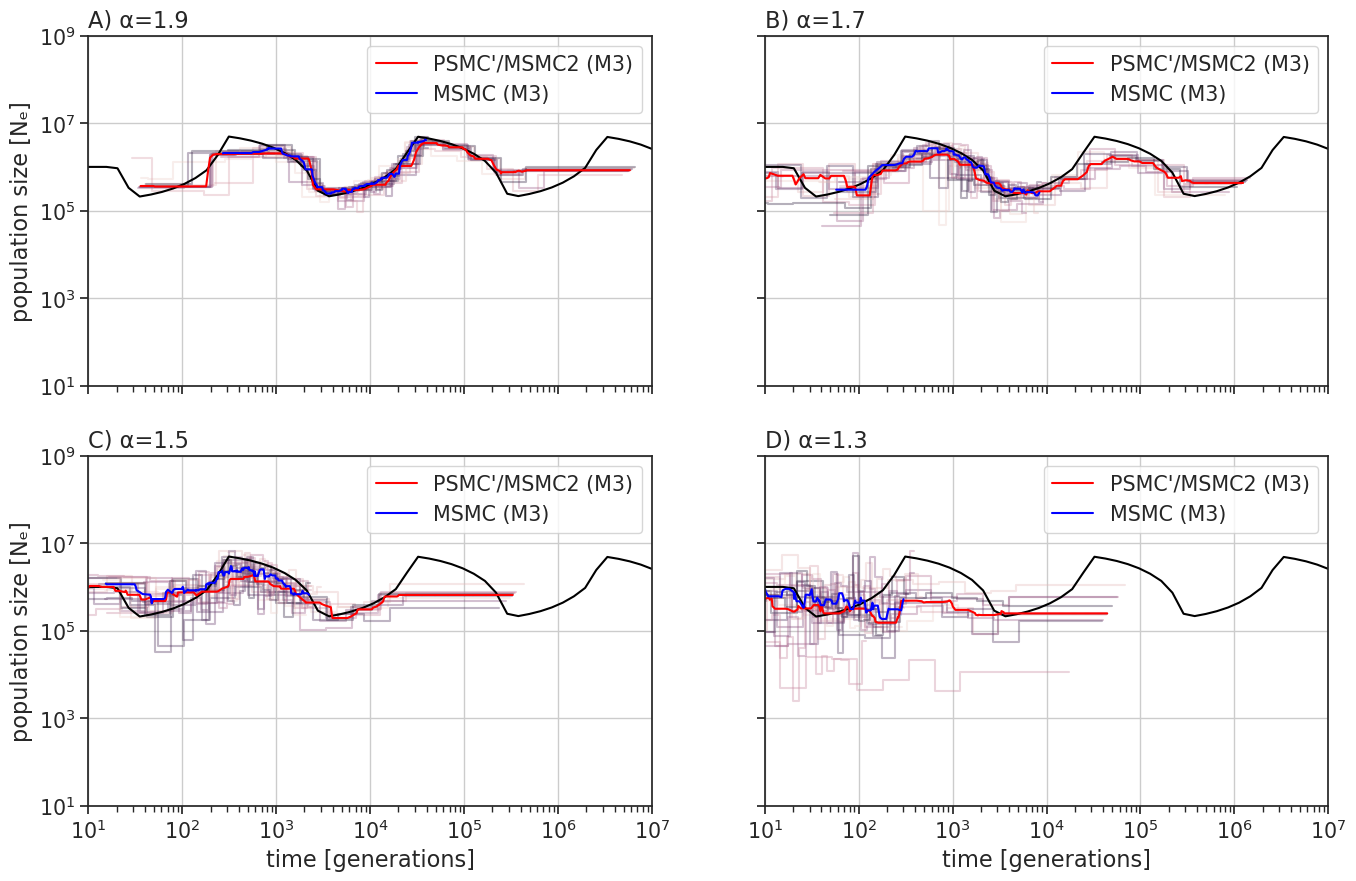

In [ ]:
sns.set(font_scale=1.35)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(16,10), sharex=True, sharey=True)

alphat = 0.35


x = "data/psmc_msmc/Fig_1_test_beta_mat_save_t_real_correct_scaling__theta_4e+06_rho_1_.csv"
y = "data/psmc_msmc/Fig_1_test_beta_mat_save_p_real_correct_scaling__theta_4e+06_rho_1_.csv"

df0 = smbc_to_plotable_df2(x=x, y=y)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[0][0]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("A) α=1.9", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)



df0 = smbc_to_plotable_df2(x=x, y=y, start_row=20)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=20)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[0][1]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("B) α=1.7", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)


df0 = smbc_to_plotable_df2(x=x, y=y, start_row=40)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=40)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[1][0]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("C) α=1.5", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)




df0 = smbc_to_plotable_df2(x=x, y=y, start_row=60)
df0["model"] = "PSMC'/MSMC2 (M3)"
df1 = smbc_to_plotable_df2(x=x, y=y, msmc_idx=1, start_row=60)
df1["model"] = "MSMC (M3)"
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()

df01["time"] = df01["time"] * 2 
df01["time_rm"] = df01["time_rm"] * 2 


ax = axs[1][1]
sns.lineplot(data=df01[df01["model"]=="PSMC'/MSMC2 (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=alphat, legend=False, ax=ax)
sns.lineplot(data=df01[df01["model"]=="MSMC (M3)"], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="blue", alpha=alphat, legend=False)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
sns.lineplot(data=df01, x="time_rm", y="population_size_rm", hue="model", palette=["red", "blue"], ax=ax).set_title("D) α=1.3", loc="left")

ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
ax.legend(loc='upper right')
ax.grid(True)



plt.yscale('log')
plt.xscale('log')
plt.ylim(10, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_1_fix.pdf", dpi=600)

# Figure 2: See LD notebook

In [ ]:
gnn = "GNN (M10)"
gnn = "GNN$\it{coal}$ (M10)"
smbc_hue = "SMβC (M3)"


In [ ]:
gnn

'GNN$\\it{coal}$ (M10)'

In [ ]:
def plot_beta_coal(x, y, t, s, title, alpha, ax):
    df0 = smbc_to_plotable_df(x=x, y=y)
    df0 = df0[["time_rm", "population_size_rm", "population_size_rstd", "population_size", "time", "replicates"]]
    df0["model"] = smbc_hue
    df1 = pd.DataFrame([t, s]).T
    df1.columns = ["time", "population_size"]
    df1["model"] = gnn
    df01 = pd.concat([df0, df1])
    df01 = df01.reset_index()
    sns.lineplot(data=df01[df01["model"]==gnn], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["blue"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
    sns.lineplot(x=population_time, y=demography, ax=ax, color="black").set_title(title, loc="left")
    ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
    ax.legend(loc='lower right')
    ax.grid(True)
    
    
def plot_kingman_coal(x, y, t, s, title, alpha, ax, demography):
    df0 = smbc_to_plotable_df(x=x, y=y)
    df0 = df0[["time_rm", "population_size_rm", "population_size_rstd", "population_size", "time", "replicates"]]
    df0["model"] = smbc_hue
    df1 = pd.DataFrame([t, s]).T
    df1.columns = ["time", "population_size"]
    df1["model"] = gnn
    df01 = pd.concat([df0, df1])
    df01 = df01.reset_index()
    sns.lineplot(data=df01[df01["model"]==gnn], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["blue"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
    sns.lineplot(x=population_time, y=demography, ax=ax, color="black").set_title(title, loc="left")
    ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
    ax.legend(loc='lower right')
    ax.grid(True)
    
    
    
def plot_kingman_scenario(axs):
    
    path = Path("./data/smbc")

    ax = axs[0]
    #x = path/("./smallpop/Table_2_small_kingman_M3_mat_x__" + str(scenario) + "_2_theta_4000_rho_1_.csv")
    #y = path/("./smallpop/Table_2_small_kingman_M3_mat_y__" + str(scenario) + "_2_theta_4000_rho_1_.csv")
    x = path/("./Table_2_small_kingman_M3_mat_x__" + str(scenario) + "_2_theta_4000_rho_1_.csv") 
    y = path/("./Table_2_small_kingman_M3_mat_y__" + str(scenario) + "_2_theta_4000_rho_1_.csv")
    t, s = times_k_small, sizes_k_small
    title = "A) Kingman Nₑ=10⁴"
    alpha = "2"
    plot_kingman_coal(x, y, t, s, title, alpha, ax, demography_small)

    #path = Path("./data/smbc/Table_2_M3")
    path = Path("./data/smbc")

    ax = axs[1]
    x = path/("Table_2_kingman_" + num_sample + "_mat_x__" + scenario + "_" + alpha + "_theta_40000_rho_1_.csv")
    y = path/("Table_2_kingman_" + num_sample + "_mat_y__" + scenario + "_" + alpha + "_theta_40000_rho_1_.csv")
    t, s = times_k, sizes_k
    title = "B) Kingman Nₑ=10⁶"
    alpha = "2"
    plot_kingman_coal(x, y, t, s, title, alpha, ax, demography)

    plt.axvline(x=10, color='k', linestyle='--')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1000, 1000_000_000)
    plt.xlim(10,10_000_000)
    
    
def plot_beta_coal_scenario(axs):
    ax = axs[0][0]
    alpha = "1.9"
    title = "A) α=1.9"
    x = path/("Table_1_" + num_sample + "_mat_x__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    y = path/("Table_1_" + num_sample + "_mat_y__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    t, s = t19, s19
    plot_beta_coal(x, y, t, s, title, alpha, ax)

    ax = axs[0][1]
    alpha = "1.7"
    title = "B) α=1.7"
    x = path/("Table_1_" + num_sample + "_mat_x__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    y = path/("Table_1_" + num_sample + "_mat_y__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    t, s = t17, s17
    plot_beta_coal(x, y, t, s, title, alpha, ax)

    ax = axs[1][0]
    alpha = "1.5"
    title = "C) α=1.5"
    x = path/("Table_1_" + num_sample + "_mat_x__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    y = path/("Table_1_" + num_sample + "_mat_y__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    t, s = t15, s15
    plot_beta_coal(x, y, t, s, title, alpha, ax)

    ax = axs[1][1]
    alpha = "1.3"
    title = "D) α=1.3"
    x = path/("Table_1_" + num_sample + "_mat_x__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    y = path/("Table_1_" + num_sample + "_mat_y__" + scenario + "_" + alpha + "_theta_4e+06_rho_1_.csv")
    t, s = t13, s13
    plot_beta_coal(x, y, t, s, title, alpha, ax)

    plt.axvline(x=10, color='k', linestyle='--')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1000, 1000_000_000)
    plt.xlim(10,10_000_000)
    
    
def get_sequence_length(alpha):
    if alpha == 1.9: return 1_000_000
    if alpha == 1.7: return 10_000_000
    if alpha == 1.5: return 50_000_000
    if alpha == 1.3: return 100_000_000


In [ ]:
import os
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from copy import deepcopy

In [ ]:
def datatize_trees(trees: list[tskit.trees.Tree]):
    data_objects = [from_networkx(nx.Graph(tree.as_dict_of_dicts())) for tree in trees]
    for data in data_objects: rename_data_attribute(data, "branch_length", "edge_weight")
    return data_objects

def rename_data_attribute(obj, old_name, new_name):
    obj.__dict__['_store'][new_name] = obj.__dict__['_store'].pop(old_name)

class MyDataset():

    def __init__(self, file_names):
        self.file_names = file_names

    def __getitem__(self, key):
        signal, mask = torch.load(open(self.file_names[key], "rb"))
        return signal, mask

    def __len__(self):
        return len(self.file_names)

    def shuffle(self):

        random.shuffle(self.file_names)



# Subfigure 9

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
demography_name = "data/kingman_sawtooth"
tree_sequence_function = kingman_sawtooth

tree_sequences, demography  = tree_sequence_function(Ne=10**4, L=10_000_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k_small, sizes_k_small = remove_low_prediction(times_k, sizes_k)
demography_small = demography

tree_sequences, demography  = tree_sequence_function(Ne=10**6, L=100_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

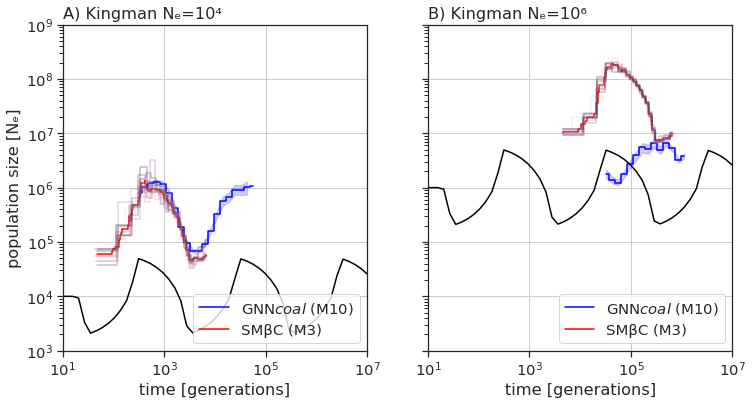

In [ ]:
num_sample = "M3"
scenario = "Sawtooth"
alpha = "2"

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plot_kingman_scenario(axs)

plt.savefig("./figures/subfigure_9_sawtooth_SMBC_GNN_twopopsizes.pdf", dpi=600)

# Subfigure 10

In [ ]:
demography_name = "data/kingman_constant"
tree_sequence_function = kingman_constant

tree_sequences, demography  = tree_sequence_function(Ne=10**4, L=10_000_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k_small, sizes_k_small = remove_low_prediction(times_k, sizes_k)
demography_small = demography

tree_sequences, demography  = tree_sequence_function(Ne=10**6, L=100_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

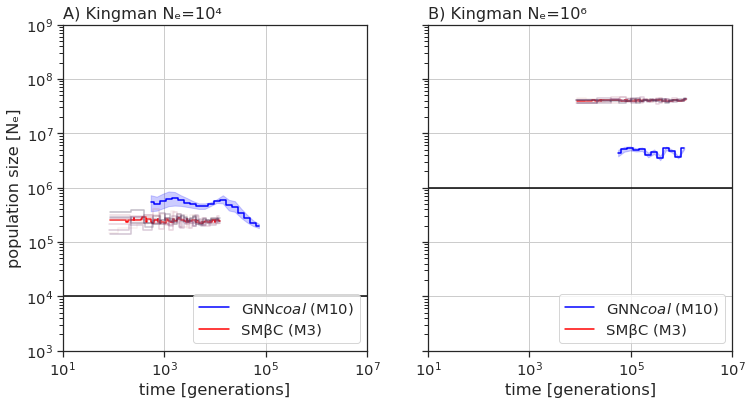

In [ ]:
num_sample = "M3"
scenario = "Constant"
alpha = "2"

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plot_kingman_scenario(axs)


plt.savefig("./figures/subfigure_10_constant_SMBC_GNN_twopopsizes.pdf", dpi=600)

# Subfigure 12

In [ ]:
demography_name = "data/kingman_increase"
tree_sequence_function = kingman_increase

tree_sequences, demography  = tree_sequence_function(Ne=10**4, L=10_000_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k_small, sizes_k_small = remove_low_prediction(times_k, sizes_k)
demography_small = demography

tree_sequences, demography  = tree_sequence_function(Ne=10**6, L=100_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

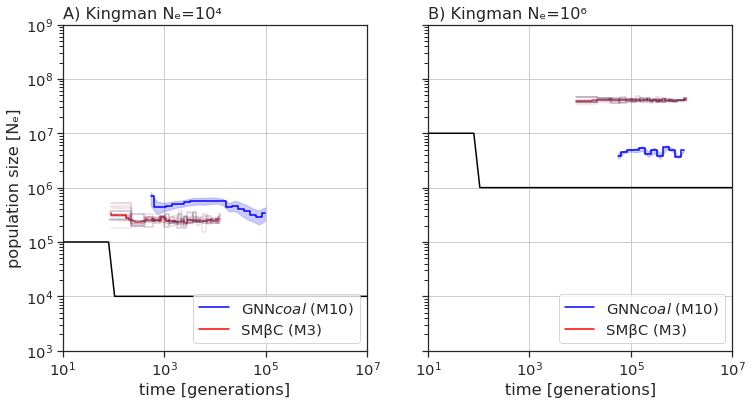

In [ ]:
num_sample = "M3"
scenario = "Increase"
alpha = "2"

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plot_kingman_scenario(axs)


plt.savefig("./figures/subfigure_12_increase_SMBC_GNN_twopopsizes.pdf", dpi=600)

# Subfigure 13

In [ ]:
demography_name = "data/kingman_decrease"
tree_sequence_function = kingman_decrease

tree_sequences, demography  = tree_sequence_function(Ne=10**4, L=10_000_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k_small, sizes_k_small = remove_low_prediction(times_k, sizes_k)
demography_small = demography

tree_sequences, demography  = tree_sequence_function(Ne=10**6, L=100_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

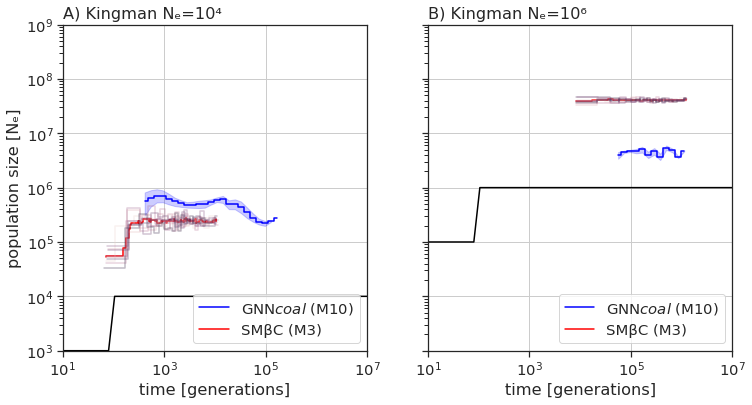

In [ ]:
num_sample = "M3"
scenario = "Decrease"
alpha = "2"

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plot_kingman_scenario(axs)

plt.savefig("./figures/subfigure_13_decrease_SMBC_GNN_twopopsizes.pdf", dpi=600)

# Subfigure 11

In [ ]:
demography_name = "data/kingman_bottleneck"
tree_sequence_function = kingman_bottleneck

tree_sequences, demography  = tree_sequence_function(Ne=10**4, L=10_000_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k_small, sizes_k_small = remove_low_prediction(times_k, sizes_k)
demography_small = demography

tree_sequences, demography  = tree_sequence_function(Ne=10**6, L=100_000)
create_dataset(tree_sequences, demography, demography_name)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

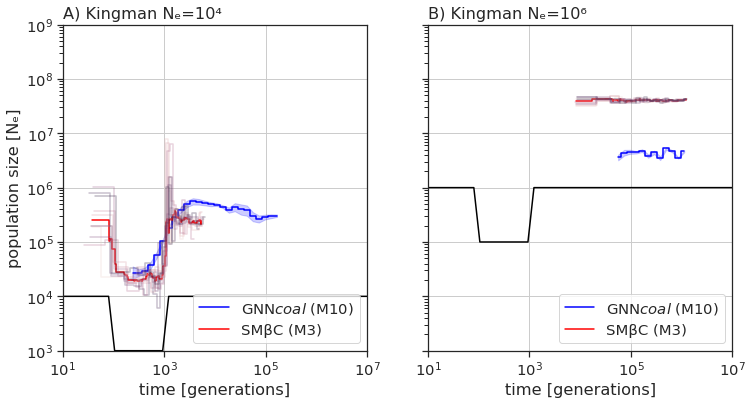

In [ ]:
num_sample = "M3"
scenario = "Bottleneck"
alpha = "2"

fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
plot_kingman_scenario(axs)

plt.savefig("./figures/subfigure_11_bottleneck_SMBC_GNN_twopopsizes.pdf", dpi=600)


In [ ]:
def run_evaluation(demography_name, tree_sequence_function, reduce=False):

    tree_sequences, demography  = tree_sequence_function(alpha=1.9)
    m = [ts.num_trees for ts in tree_sequences]
    print(f"Mean tree number: {np.mean(m)}")
    print(m)
    
    create_dataset(tree_sequences, demography, demography_name, reduce)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times19, sizes19, unmasked_times19, unmasked_sizes19 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.7)
    m = [ts.num_trees for ts in tree_sequences]
    print(f"Mean tree number: {np.mean(m)}")
    print(m)

    create_dataset(tree_sequences, demography, demography_name, reduce)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times17, sizes17, unmasked_times17, unmasked_sizes17 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.5)
    m = [ts.num_trees for ts in tree_sequences]
    print(f"Mean tree number: {np.mean(m)}")
    print(m)
    
    create_dataset(tree_sequences, demography, demography_name, reduce)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times15, sizes15, unmasked_times15, unmasked_sizes15 = get_xy_variable(dataset)

    tree_sequences, demography  = tree_sequence_function(alpha=1.3)
    m = [ts.num_trees for ts in tree_sequences]
    print(f"Mean tree number: {np.mean(m)}")
    print(m)
    
    create_dataset(tree_sequences, demography, demography_name, reduce)
    dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
    times13, sizes13, unmasked_times13, unmasked_sizes13 = get_xy_variable(dataset)
    
    return times19, sizes19, unmasked_times19, unmasked_sizes19, times17, sizes17, unmasked_times17, unmasked_sizes17, times15, sizes15, unmasked_times15, unmasked_sizes15, times13, sizes13, unmasked_times13, unmasked_sizes13, demography

# Figure 3

In [ ]:
demography_name = "data/sawtooth"
tree_sequence_function = sawtooth
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1478.2
[1527, 1698, 1257, 1695, 1321, 1399, 1652, 1592, 1372, 1269]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3377.1
[3998, 3573, 3847, 3115, 3391, 2904, 3310, 2703, 3557, 3373]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4359.0
[4914, 4378, 3452, 4923, 4185, 4275, 4109, 5070, 4241, 4043]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1053.0
[951, 1669, 1054, 382, 1361, 840, 1314, 990, 834, 1135]


  0%|          | 0/10 [00:00<?, ?it/s]

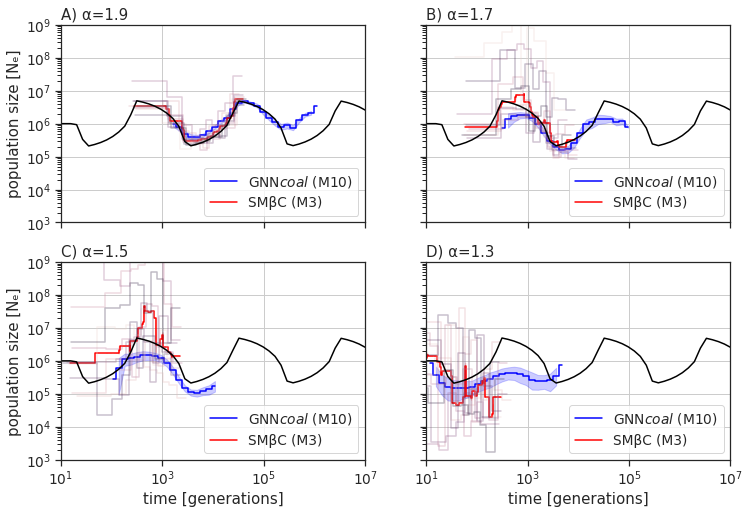

In [ ]:
path = Path("./data/smbc/Table_1_M3")
num_sample = "M3"
scenario = "Sawtooth"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

plot_beta_coal_scenario(axs)

plt.savefig("./figures/figure_3_sawtooth_SMBC_GNN.pdf", dpi=600)

# Subfigure 5

In [ ]:
demography_name = "data/bottleneck"
tree_sequence_function = bottleneck

t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1172.0
[976, 1107, 1173, 1131, 1065, 1125, 1317, 1319, 1430, 1077]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 2755.3
[3220, 3325, 1909, 2641, 3444, 2852, 2569, 3834, 1546, 2213]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1757.9
[1712, 1747, 1868, 2505, 1018, 1886, 1995, 1536, 1906, 1406]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 860.9
[739, 1058, 634, 651, 1077, 556, 971, 961, 918, 1044]


  0%|          | 0/10 [00:00<?, ?it/s]

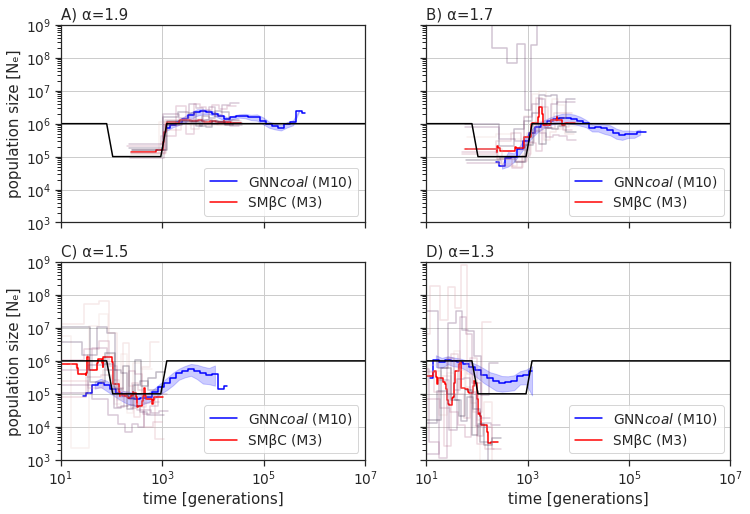

In [ ]:
path = Path("./data/smbc/Table_1_M3")
num_sample = "M3"
scenario = "Bottleneck"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

plot_beta_coal_scenario(axs)

plt.savefig("./figures/subfigure_5_bottleneck_SMBC_GNN.pdf", dpi=600)

#  Subfigure 7

In [ ]:
demography_name = "data/decrease"
tree_sequence_function = decrease

t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1534.1
[1473, 1800, 1378, 1514, 1187, 1607, 1706, 1635, 1706, 1335]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4677.6
[3656, 4407, 6079, 4131, 5252, 4085, 4183, 5440, 4520, 5023]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3351.5
[4213, 1982, 3993, 2566, 4238, 4578, 2260, 3132, 2426, 4127]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 721.0
[849, 261, 799, 541, 1069, 800, 367, 697, 592, 1235]


  0%|          | 0/10 [00:00<?, ?it/s]

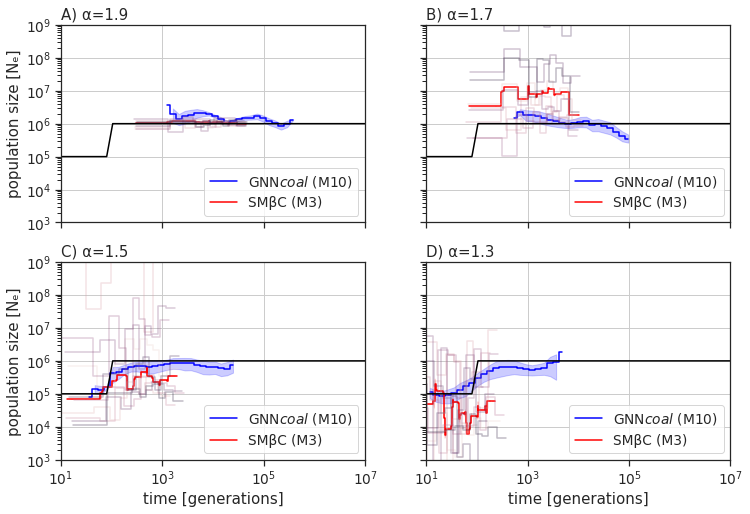

In [ ]:
path = Path("./data/smbc/Table_1_M3")
num_sample = "M3"
scenario = "Decrease"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

plot_beta_coal_scenario(axs)

plt.savefig("./figures/subfigure_7_decrease.pdf", dpi=600)

# Subfigure 6

In [ ]:
demography_name = "data/increase"
tree_sequence_function = increase

t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1596.5
[1609, 1671, 1657, 1597, 1219, 1588, 1706, 1635, 1703, 1580]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 5111.9
[4618, 5019, 6130, 4253, 5502, 3855, 5781, 5479, 5487, 4995]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4715.5
[5882, 5394, 3625, 4558, 4063, 4946, 3666, 5354, 4942, 4725]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1652.7
[483, 1839, 1837, 2286, 1718, 1314, 1815, 2030, 1553, 1652]


  0%|          | 0/10 [00:00<?, ?it/s]

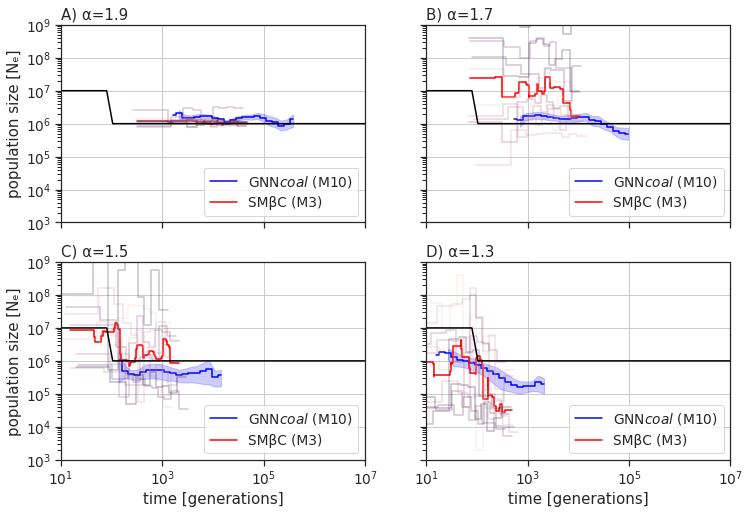

In [ ]:
path = Path("./data/smbc/Table_1_M3")
num_sample = "M3"
scenario = "Increase"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

plot_beta_coal_scenario(axs)

plt.savefig("./figures/subfigure_6_increase.pdf", dpi=600)

In [ ]:
demography_name = "data/constant"
tree_sequence_function = constant

t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1532.4
[1570, 1765, 1696, 1727, 1268, 1528, 1438, 1400, 1733, 1199]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4928.6
[4601, 4661, 5805, 4705, 4799, 4360, 5798, 5391, 4642, 4524]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3719.8
[4103, 3916, 3851, 4460, 4147, 4535, 2939, 3727, 1655, 3865]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1165.2
[1054, 1848, 980, 688, 1070, 721, 1273, 1245, 1404, 1369]


  0%|          | 0/10 [00:00<?, ?it/s]

#  Subfigure 4

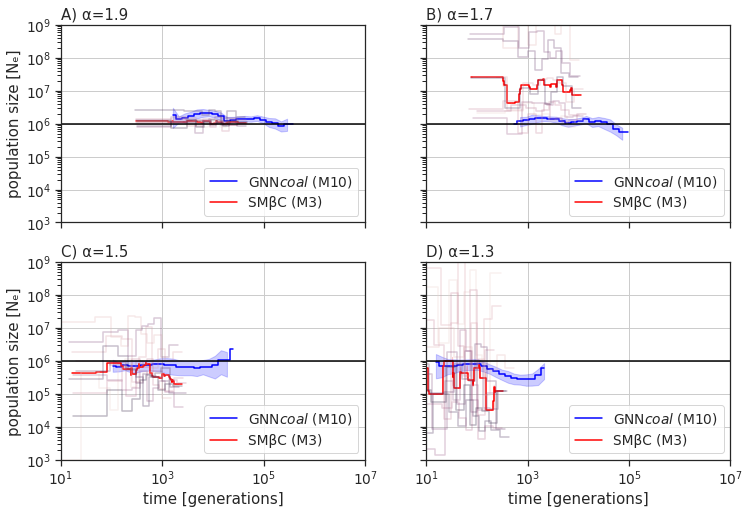

In [ ]:
path = Path("./data/smbc/Table_1_M3")
num_sample = "M3"
scenario = "Constant"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

plot_beta_coal_scenario(axs)

plt.savefig("./figures/subfigure_4_constant.pdf", dpi=600)

# Subfigure 8

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

demography_name = "data/sawtooth"
tree_sequence_function = sawtooth
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1478.2
[1527, 1698, 1257, 1695, 1321, 1399, 1652, 1592, 1372, 1269]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3377.1
[3998, 3573, 3847, 3115, 3391, 2904, 3310, 2703, 3557, 3373]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4359.0
[4914, 4378, 3452, 4923, 4185, 4275, 4109, 5070, 4241, 4043]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1053.0
[951, 1669, 1054, 382, 1361, 840, 1314, 990, 834, 1135]


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
#model.load_state_dict(torch.load("./large_models_demo/mmc_diffpool_model_demography_inference1_999999.pth"))
model.load_state_dict(torch.load("./trained_models/demography_models_M3/mmc_diffpool_model_demography_inference_intermediate0_1000000.pth"))

demography_name = "data/sawtooth"
tree_sequence_function = sawtooth
t19m, s19m, ut19m, us19m, t17m, s17m, ut17m, us17m, t15m, s15m, ut15m, us15m, t13m, s13m, ut13m, us13m, demography = run_evaluation(demography_name, tree_sequence_function, reduce=True)
ut19m, us19m = remove_low_prediction(ut19m, us19m)
ut17m, us17m = remove_low_prediction(ut17m, us17m)
ut15m, us15m = remove_low_prediction(ut15m, us15m)
ut13m, us13m = remove_low_prediction(ut13m, us13m)

Mean tree number: 1478.2
[1527, 1698, 1257, 1695, 1321, 1399, 1652, 1592, 1372, 1269]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3377.1
[3998, 3573, 3847, 3115, 3391, 2904, 3310, 2703, 3557, 3373]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4359.0
[4914, 4378, 3452, 4923, 4185, 4275, 4109, 5070, 4241, 4043]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1053.0
[951, 1669, 1054, 382, 1361, 840, 1314, 990, 834, 1135]


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def plot_beta_M3M10(ax, t0, s0, t1, s1, title):
    t, s = t0, s0
    df0 = pd.DataFrame([t, s]).T
    df0.columns = ["time", "population_size"]
    df0["model"] = "GNN$\it{coal}$ (M3)"

    t, s = t1, s1
    df1 = pd.DataFrame([t, s]).T
    df1.columns = ["time", "population_size"]
    df1["model"] = "GNN$\it{coal}$ (M10)"

    df01 = pd.concat([df0, df1])
    df01 = df01.reset_index()
    sns.lineplot(data=df01[df01["model"]=="GNN$\it{coal}$ (M3)"], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["#739bd0"])
    sns.lineplot(data=df01[df01["model"]=="GNN$\it{coal}$ (M10)"], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["blue"])
    sns.lineplot(x=population_time, y=demography, ax=ax, color="black").set_title(title, loc="left")
    ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
    ax.legend(loc='lower right')
    ax.grid(True)

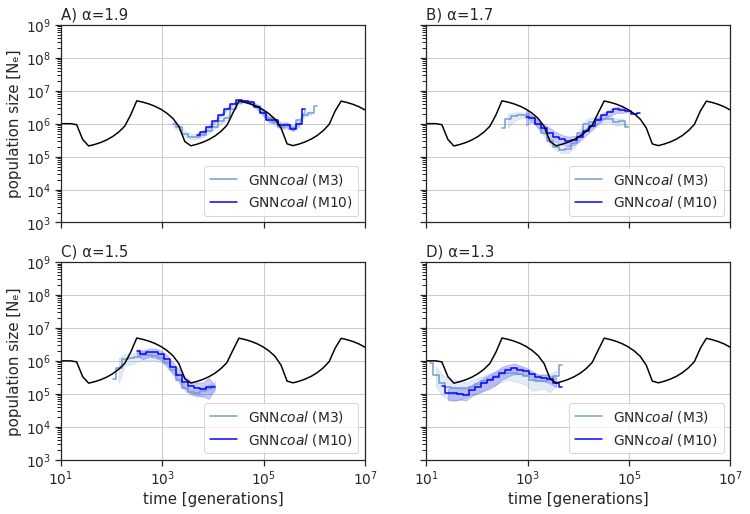

In [ ]:
scenario = "Sawtooth"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


plot_beta_M3M10(axs[0][0], t19, s19, t19m, s19m, "A) α=1.9")
plot_beta_M3M10(axs[0][1], t17, s17, t17m, s17m, "B) α=1.7")
plot_beta_M3M10(axs[1][0], t15, s15, t15m, s15m, "C) α=1.5")
plot_beta_M3M10(axs[1][1], t13, s13, t13m, s13m, "D) α=1.3")


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_sawtooth_GNN_M3M10.pdf", dpi=600)

# Not part of manuscript or appendix  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

demography_name = "data/bottleneck"
tree_sequence_function = bottleneck
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1172.0
[976, 1107, 1173, 1131, 1065, 1125, 1317, 1319, 1430, 1077]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 2755.3
[3220, 3325, 1909, 2641, 3444, 2852, 2569, 3834, 1546, 2213]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1757.9
[1712, 1747, 1868, 2505, 1018, 1886, 1995, 1536, 1906, 1406]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 860.9
[739, 1058, 634, 651, 1077, 556, 971, 961, 918, 1044]


  0%|          | 0/10 [00:00<?, ?it/s]

# Not part of manuscript or appendix  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
#model.load_state_dict(torch.load("./large_models_demo/mmc_diffpool_model_demography_inference1_999999.pth"))
model.load_state_dict(torch.load("./trained_models/demography_models_M3/mmc_diffpool_model_demography_inference_intermediate0_1000000.pth"))

demography_name = "data/bottleneck"
tree_sequence_function = bottleneck
t19m, s19m, ut19m, us19m, t17m, s17m, ut17m, us17m, t15m, s15m, ut15m, us15m, t13m, s13m, ut13m, us13m, demography = run_evaluation(demography_name, tree_sequence_function, reduce=True)
ut19m, us19m = remove_low_prediction(ut19m, us19m)
ut17m, us17m = remove_low_prediction(ut17m, us17m)
ut15m, us15m = remove_low_prediction(ut15m, us15m)
ut13m, us13m = remove_low_prediction(ut13m, us13m)

Mean tree number: 1172.0
[976, 1107, 1173, 1131, 1065, 1125, 1317, 1319, 1430, 1077]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 2755.3
[3220, 3325, 1909, 2641, 3444, 2852, 2569, 3834, 1546, 2213]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1757.9
[1712, 1747, 1868, 2505, 1018, 1886, 1995, 1536, 1906, 1406]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 860.9
[739, 1058, 634, 651, 1077, 556, 971, 961, 918, 1044]


  0%|          | 0/10 [00:00<?, ?it/s]

# Not part of manuscript or appendix  

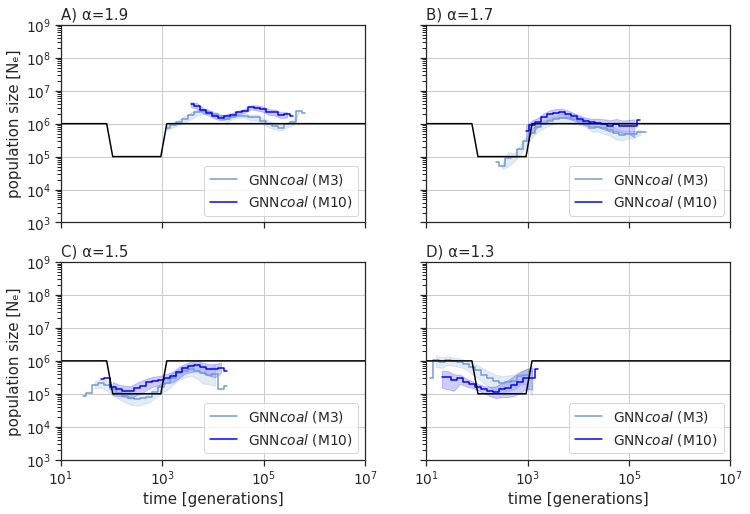

In [ ]:
scenario = "Bottleneck"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


plot_beta_M3M10(axs[0][0], t19, s19, t19m, s19m, "A) α=1.9")
plot_beta_M3M10(axs[0][1], t17, s17, t17m, s17m, "B) α=1.7")
plot_beta_M3M10(axs[1][0], t15, s15, t15m, s15m, "C) α=1.5")
plot_beta_M3M10(axs[1][1], t13, s13, t13m, s13m, "D) α=1.3")


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_bottleneck_GNN_M3M10.png", dpi=400)

# Not part of manuscript or appendix  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

demography_name = "data/constant"
tree_sequence_function = constant
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1532.4
[1570, 1765, 1696, 1727, 1268, 1528, 1438, 1400, 1733, 1199]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4928.6
[4601, 4661, 5805, 4705, 4799, 4360, 5798, 5391, 4642, 4524]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3719.8
[4103, 3916, 3851, 4460, 4147, 4535, 2939, 3727, 1655, 3865]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1165.2
[1054, 1848, 980, 688, 1070, 721, 1273, 1245, 1404, 1369]


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
#model.load_state_dict(torch.load("./large_models_demo/mmc_diffpool_model_demography_inference1_999999.pth"))
model.load_state_dict(torch.load("./trained_models/demography_models_M3/mmc_diffpool_model_demography_inference_intermediate0_1000000.pth"))

demography_name = "data/constant"
tree_sequence_function = constant
t19m, s19m, ut19m, us19m, t17m, s17m, ut17m, us17m, t15m, s15m, ut15m, us15m, t13m, s13m, ut13m, us13m, demography = run_evaluation(demography_name, tree_sequence_function, reduce=True)
ut19m, us19m = remove_low_prediction(ut19m, us19m)
ut17m, us17m = remove_low_prediction(ut17m, us17m)
ut15m, us15m = remove_low_prediction(ut15m, us15m)
ut13m, us13m = remove_low_prediction(ut13m, us13m)

Mean tree number: 1532.4
[1570, 1765, 1696, 1727, 1268, 1528, 1438, 1400, 1733, 1199]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4928.6
[4601, 4661, 5805, 4705, 4799, 4360, 5798, 5391, 4642, 4524]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3719.8
[4103, 3916, 3851, 4460, 4147, 4535, 2939, 3727, 1655, 3865]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1165.2
[1054, 1848, 980, 688, 1070, 721, 1273, 1245, 1404, 1369]


  0%|          | 0/10 [00:00<?, ?it/s]

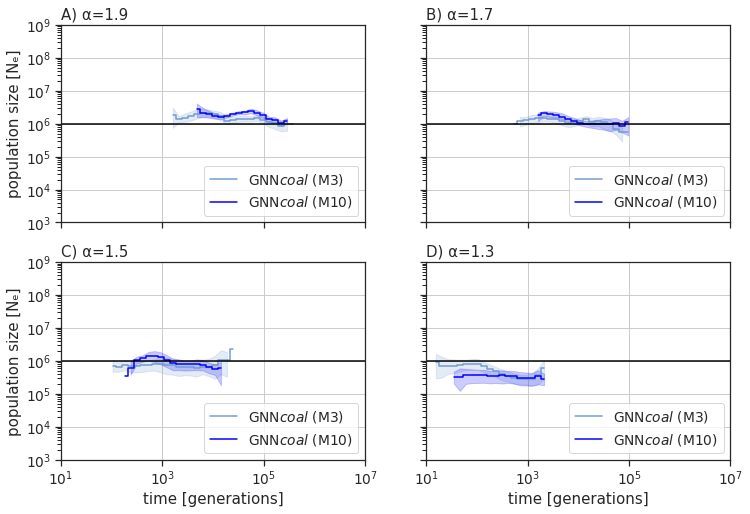

In [ ]:
scenario = "Constant"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


plot_beta_M3M10(axs[0][0], t19, s19, t19m, s19m, "A) α=1.9")
plot_beta_M3M10(axs[0][1], t17, s17, t17m, s17m, "B) α=1.7")
plot_beta_M3M10(axs[1][0], t15, s15, t15m, s15m, "C) α=1.5")
plot_beta_M3M10(axs[1][1], t13, s13, t13m, s13m, "D) α=1.3")


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_constant_GNN_M3M10.png", dpi=400)

# Not part of manuscript or appendix  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

demography_name = "data/decrease"
tree_sequence_function = decrease
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1534.1
[1473, 1800, 1378, 1514, 1187, 1607, 1706, 1635, 1706, 1335]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4677.6
[3656, 4407, 6079, 4131, 5252, 4085, 4183, 5440, 4520, 5023]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3351.5
[4213, 1982, 3993, 2566, 4238, 4578, 2260, 3132, 2426, 4127]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 721.0
[849, 261, 799, 541, 1069, 800, 367, 697, 592, 1235]


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
#model.load_state_dict(torch.load("./large_models_demo/mmc_diffpool_model_demography_inference1_999999.pth"))
model.load_state_dict(torch.load("./trained_models/demography_models_M3/mmc_diffpool_model_demography_inference_intermediate0_1000000.pth"))

demography_name = "data/decrease"
tree_sequence_function = decrease
t19m, s19m, ut19m, us19m, t17m, s17m, ut17m, us17m, t15m, s15m, ut15m, us15m, t13m, s13m, ut13m, us13m, demography = run_evaluation(demography_name, tree_sequence_function, reduce=True)
ut19m, us19m = remove_low_prediction(ut19m, us19m)
ut17m, us17m = remove_low_prediction(ut17m, us17m)
ut15m, us15m = remove_low_prediction(ut15m, us15m)
ut13m, us13m = remove_low_prediction(ut13m, us13m)

Mean tree number: 1534.1
[1473, 1800, 1378, 1514, 1187, 1607, 1706, 1635, 1706, 1335]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4677.6
[3656, 4407, 6079, 4131, 5252, 4085, 4183, 5440, 4520, 5023]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 3351.5
[4213, 1982, 3993, 2566, 4238, 4578, 2260, 3132, 2426, 4127]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 721.0
[849, 261, 799, 541, 1069, 800, 367, 697, 592, 1235]


  0%|          | 0/10 [00:00<?, ?it/s]

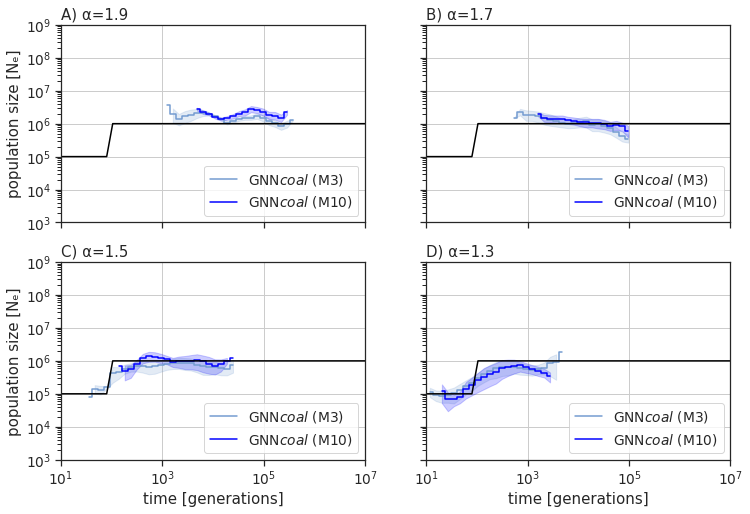

In [ ]:
scenario = "Decrease"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


plot_beta_M3M10(axs[0][0], t19, s19, t19m, s19m, "A) α=1.9")
plot_beta_M3M10(axs[0][1], t17, s17, t17m, s17m, "B) α=1.7")
plot_beta_M3M10(axs[1][0], t15, s15, t15m, s15m, "C) α=1.5")
plot_beta_M3M10(axs[1][1], t13, s13, t13m, s13m, "D) α=1.3")


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_decrease_GNN_M3M10.png", dpi=400)

# Not part of manuscript or appendix  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

demography_name = "data/increase"
tree_sequence_function = increase
t19, s19, ut19, us19, t17, s17, ut17, us17, t15, s15, ut15, us15, t13, s13, ut13, us13, demography = run_evaluation(demography_name, tree_sequence_function)
ut19, us19 = remove_low_prediction(ut19, us19)
ut17, us17 = remove_low_prediction(ut17, us17)
ut15, us15 = remove_low_prediction(ut15, us15)
ut13, us13 = remove_low_prediction(ut13, us13)

Mean tree number: 1596.5
[1609, 1671, 1657, 1597, 1219, 1588, 1706, 1635, 1703, 1580]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 5111.9
[4618, 5019, 6130, 4253, 5502, 3855, 5781, 5479, 5487, 4995]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4715.5
[5882, 5394, 3625, 4558, 4063, 4946, 3666, 5354, 4942, 4725]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1652.7
[483, 1839, 1837, 2286, 1718, 1314, 1815, 2030, 1553, 1652]


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
#model.load_state_dict(torch.load("./large_models_demo/mmc_diffpool_model_demography_inference1_999999.pth"))
model.load_state_dict(torch.load("./trained_models/demography_models_M3/mmc_diffpool_model_demography_inference_intermediate0_1000000.pth"))

demography_name = "data/increase"
tree_sequence_function = increase
t19m, s19m, ut19m, us19m, t17m, s17m, ut17m, us17m, t15m, s15m, ut15m, us15m, t13m, s13m, ut13m, us13m, demography = run_evaluation(demography_name, tree_sequence_function, reduce=True)
ut19m, us19m = remove_low_prediction(ut19m, us19m)
ut17m, us17m = remove_low_prediction(ut17m, us17m)
ut15m, us15m = remove_low_prediction(ut15m, us15m)
ut13m, us13m = remove_low_prediction(ut13m, us13m)

Mean tree number: 1596.5
[1609, 1671, 1657, 1597, 1219, 1588, 1706, 1635, 1703, 1580]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 5111.9
[4618, 5019, 6130, 4253, 5502, 3855, 5781, 5479, 5487, 4995]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 4715.5
[5882, 5394, 3625, 4558, 4063, 4946, 3666, 5354, 4942, 4725]


  0%|          | 0/10 [00:00<?, ?it/s]

Mean tree number: 1652.7
[483, 1839, 1837, 2286, 1718, 1314, 1815, 2030, 1553, 1652]


  0%|          | 0/10 [00:00<?, ?it/s]

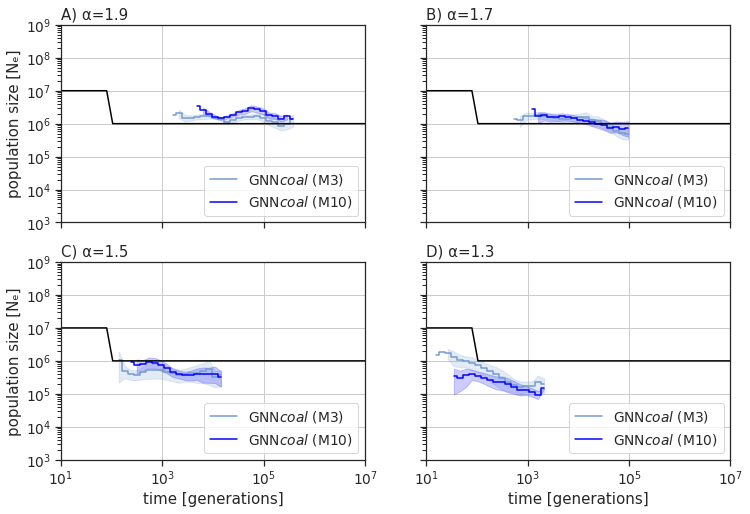

In [ ]:
scenario = "Increase"
alphas = ["1.9", "1.7", "1.5", "1.3"]

sns.set(font_scale=1.25)
sns.set_style("ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


plot_beta_M3M10(axs[0][0], t19, s19, t19m, s19m, "A) α=1.9")
plot_beta_M3M10(axs[0][1], t17, s17, t17m, s17m, "B) α=1.7")
plot_beta_M3M10(axs[1][0], t15, s15, t15m, s15m, "C) α=1.5")
plot_beta_M3M10(axs[1][1], t13, s13, t13m, s13m, "D) α=1.3")


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.savefig("./figures/subfigure_increase_GNN_M3M10.png", dpi=400)

# Figure 4

In [ ]:
def infer_alpha(dataset):
    y_trues = []
    y_hats = []
    with torch.no_grad():
        bs = 500
        for i, (data_objects, mask) in enumerate(dataset):
            if len(data_objects) == 1:
                data_objects.append(data_objects[0])
            dl = DataLoader(data_objects, batch_size=len(data_objects))
            for batch in dl:
                batch = batch.to(device)
                y_hat = model(batch)
                y_hat = np.mean(y_hat.cpu().numpy())
                y_hat = np.round(y_hat, 2).item()
                y_hats.append(y_hat)
    return y_hats

def calculate_stats(y_hats):
    mean = np.mean(y_hats)
    coef_var = np.std(y_hats) / np.mean(y_hats)
    return np.round(mean,3), np.round(coef_var,3)


class AlphaInferenceModel(nn.Module):
    
    def __init__(self, DemographyNet, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, time_window//4)
        self.l3 = nn.Linear(time_window//4, 1)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l3(F.relu(self.l2(F.relu(self.l1(x)))))

In [ ]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
model = AlphaInferenceModel(demography_net)
model_path = "./trained_models/alpha_inf/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model.load_state_dict(torch.load(model_path))
model = model.to(device)
criterion = RMSELoss

In [ ]:
alphas = [1.99]

results = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [kingman_constant, kingman_bottleneck, kingman_increase, kingman_decrease, kingman_sawtooth]):
    
    demography_results = {}
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(Ne=10_000, L=10_000_000)
        create_dataset(tree_sequences, demography, demography_name)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        
    results[demo_name] = demography_results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#
kingman_alpha_estimates_M10_0 = pd.DataFrame(results); kingman_alpha_estimates_M10_0

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.99,"(1.995, 0.005)","(1.986, 0.005)","(1.994, 0.003)","(1.985, 0.005)","(1.993, 0.004)"


In [ ]:
alphas = [1.99]

results = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [kingman_constant, kingman_bottleneck, kingman_increase, kingman_decrease, kingman_sawtooth]):
    
    demography_results = {}
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(Ne=1_000_000, L=100_000)
        create_dataset(tree_sequences, demography, demography_name)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        
    results[demo_name] = demography_results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#
kingman_alpha_estimates_M10_0_large = pd.DataFrame(results); kingman_alpha_estimates_M10_0_large

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.99,"(1.995, 0.003)","(1.99, 0.003)","(1.991, 0.004)","(1.989, 0.004)","(1.994, 0.002)"


In [ ]:
alphas = [1.9, 1.7, 1.5, 1.3]

results = {}
results2 = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [constant, bottleneck, increase, decrease, sawtooth]):
    
    demography_results = {}
    demography_results2 = {}
    
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(alpha=alpha)
        create_dataset(tree_sequences, demography, demography_name)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        demography_results2[alpha] = y_hats
        
    results[demo_name] = demography_results
    results2[demo_name] = demography_results2

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
alpha_estimates_M10_0 = pd.DataFrame(results); alpha_estimates_M10_0

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.9,"(1.883, 0.032)","(1.907, 0.024)","(1.878, 0.022)","(1.883, 0.036)","(1.935, 0.015)"
1.7,"(1.771, 0.029)","(1.764, 0.032)","(1.736, 0.028)","(1.776, 0.037)","(1.742, 0.03)"
1.5,"(1.557, 0.024)","(1.526, 0.031)","(1.613, 0.033)","(1.546, 0.028)","(1.559, 0.016)"
1.3,"(1.332, 0.031)","(1.284, 0.039)","(1.382, 0.023)","(1.296, 0.031)","(1.359, 0.048)"


In [ ]:
alpha_estimates_M10 = pd.DataFrame(results2)
alpha_estimates_M10.to_csv("GNN_M10_alpha_estimates.csv")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
model = AlphaInferenceModel(demography_net)
model_path = "./trained_models/alpha_inf_M3/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model.load_state_dict(torch.load(model_path))
model = model.to(device)
criterion = RMSELoss

In [ ]:
alphas = [1.99]

results = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [kingman_constant, kingman_bottleneck, kingman_increase, kingman_decrease, kingman_sawtooth]):
    
    demography_results = {}
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(Ne=10_000, L=10_000_000)
        create_dataset(tree_sequences, demography, demography_name, reduce=True)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        
    results[demo_name] = demography_results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#
kingman_alpha_estimates_M3_0 = pd.DataFrame(results); kingman_alpha_estimates_M3_0

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.99,"(1.988, 0.002)","(1.976, 0.003)","(1.989, 0.002)","(1.979, 0.009)","(1.99, 0.002)"


In [ ]:
alphas = [1.99]

results = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [kingman_constant, kingman_bottleneck, kingman_increase, kingman_decrease, kingman_sawtooth]):
    
    demography_results = {}
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(Ne=1_000_000, L=100_000)
        create_dataset(tree_sequences, demography, demography_name, reduce=True)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        
    results[demo_name] = demography_results

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#
kingman_alpha_estimates_M3_0_large = pd.DataFrame(results); kingman_alpha_estimates_M3_0_large

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.99,"(1.989, 0.002)","(1.988, 0.002)","(1.986, 0.003)","(1.987, 0.003)","(1.993, 0.004)"


In [ ]:
alphas = [1.9, 1.7, 1.5, 1.3]

results = {}
results2 = {}
for demo_name, demo_fnc in zip(["data/constant", "data/bottleneck", "data/increase", "data/decrease", "data/sawtooth"],
                               [constant, bottleneck, increase, decrease, sawtooth]):
    
    demography_results = {}
    demography_results2 = {}
    
    for alpha in alphas:
        tree_sequence_function = demo_fnc
        demography_name = demo_name
        tree_sequences, demography  = tree_sequence_function(alpha=alpha)
        create_dataset(tree_sequences, demography, demography_name, reduce=True)
        dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
        y_hats = infer_alpha(dataset)
        stats = calculate_stats(y_hats)
        demography_results[alpha] = stats
        demography_results2[alpha] = y_hats
        
    results[demo_name] = demography_results
    results2[demo_name] = demography_results2

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
alpha_estimates_M3 = pd.DataFrame(results); alpha_estimates_M3

,data/constant,data/bottleneck,data/increase,data/decrease,data/sawtooth
1.9,"(1.895, 0.032)","(1.909, 0.034)","(1.892, 0.035)","(1.927, 0.033)","(1.952, 0.022)"
1.7,"(1.768, 0.016)","(1.781, 0.035)","(1.779, 0.024)","(1.806, 0.043)","(1.81, 0.016)"
1.5,"(1.613, 0.02)","(1.575, 0.024)","(1.642, 0.024)","(1.604, 0.025)","(1.614, 0.036)"
1.3,"(1.388, 0.023)","(1.341, 0.022)","(1.434, 0.017)","(1.395, 0.021)","(1.41, 0.027)"


In [ ]:
alpha_estimates_M3 = pd.DataFrame(results2)
alpha_estimates_M3.to_csv("GNN_M3_alpha_estimates.csv")

In [ ]:
gnn_alpha = pd.read_csv("GNN_M10_alpha_estimates.csv")
gnn_alpha_m3 = pd.read_csv("GNN_M3_alpha_estimates.csv")

In [ ]:
gnn_alpha_m3.columns = ["alpha", 'constant','bottleneck', 'increase', 'decrease', 'sawtooth']
gnn_alpha.columns = ["alpha", 'constant','bottleneck', 'increase', 'decrease', 'sawtooth']

In [ ]:
sns.set(font_scale=1.25)
sns.set_style("ticks")

demography = "Constant"
file = "./data/smbc-alpha/Table_1_M3_n40__Constant__alpha_theta_4e+06_rho_1_.csv"
df0 = pd.read_csv(file).iloc[:,1:]
df0["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df0 = df0.melt("alpha")[["alpha", "value"]]
df0["model"] = "SMβC-M3"
df0["demography"] = demography

file = "./data/smbc-alpha/Table_1_M4__Constant__alpha_theta_4e+06_rho_1_.csv"
df01 = pd.read_csv(file).iloc[:,1:]
df01["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df01 = df01.melt("alpha")[["alpha", "value"]]
df01["model"] = "SMβC-M4"
df01["demography"] = demography



demography = "Increase"
file = "./data/smbc-alpha/Table_1_M3_n40__Increase__alpha_theta_4e+06_rho_1_.csv"
df1 = pd.read_csv(file).iloc[:,1:]
df1["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df1 = df1.melt("alpha")[["alpha", "value"]]
df1["model"] = "SMβC-M3"
df1["demography"] = demography

file = "./data/smbc-alpha/Table_1_M4__Increase__alpha_theta_4e+06_rho_1_.csv"
df11 = pd.read_csv(file).iloc[:,1:]
df11["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df11 = df11.melt("alpha")[["alpha", "value"]]
df11["model"] = "SMβC-M4"
df11["demography"] = demography


demography = "Decrease"
file = "./data/smbc-alpha/Table_1_M3_n40__Decrease__alpha_theta_4e+06_rho_1_.csv"
df2 = pd.read_csv(file).iloc[:,1:]
df2["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df2 = df2.melt("alpha")[["alpha", "value"]]
df2["model"] = "SMβC-M3"
df2["demography"] = demography

file = "./data/smbc-alpha/Table_1_M4__Decrease__alpha_theta_4e+06_rho_1_.csv"
df21 = pd.read_csv(file).iloc[:,1:]
df21["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df21 = df21.melt("alpha")[["alpha", "value"]]
df21["model"] = "SMβC-M4"
df21["demography"] = demography




demography = "Bottleneck"
file = "./data/smbc-alpha/Table_1_M3_n40__Bottleneck__alpha_theta_4e+06_rho_1_.csv"
df3 = pd.read_csv(file).iloc[:,1:]
df3["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df3 = df3.melt("alpha")[["alpha", "value"]]
df3["model"] = "SMβC-M3"
df3["demography"] = demography

file = "./data/smbc-alpha/Table_1_M4__Bottleneck__alpha_theta_4e+06_rho_1_.csv"
df31 = pd.read_csv(file).iloc[:,1:]
df31["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df31 = df31.melt("alpha")[["alpha", "value"]]
df31["model"] = "SMβC-M4"
df31["demography"] = demography



demography = "Sawtooth"
file = "./data/smbc-alpha/Table_1_M3__Sawtooth__alpha_theta_4e+06_rho_1_.csv"
df4 = pd.read_csv(file).iloc[:,1:]
df4["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df4 = df4.melt("alpha")[["alpha", "value"]]
df4["model"] = "SMβC-M3"
df4["demography"] = demography

file = "./data/smbc-alpha/Table_1_M4__Sawtooth__alpha_theta_4e+06_rho_1_.csv"
df41 = pd.read_csv(file).iloc[:,1:]
df41["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df41 = df41.melt("alpha")[["alpha", "value"]]
df41["model"] = "SMβC-M4"
df41["demography"] = demography



demography = "constant"
df50 = pd.DataFrame([eval(gnn_alpha[demography][i]) for i in range(4)])
df50["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df50 = df50.melt("alpha")[["alpha", "value"]]
df50["model"] = "GNN"
df50["demography"] = demography

df51 = pd.DataFrame([eval(gnn_alpha_m3[demography][i]) for i in range(4)])
df51["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df51 = df51.melt("alpha")[["alpha", "value"]]
df51["model"] = "GNN-M3"
df51["demography"] = demography


demography = "increase"
df60 = pd.DataFrame([eval(gnn_alpha[demography][i]) for i in range(4)])
df60["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df60 = df60.melt("alpha")[["alpha", "value"]]
df60["model"] = "GNN"
df60["demography"] = demography

df61 = pd.DataFrame([eval(gnn_alpha_m3[demography][i]) for i in range(4)])
df61["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df61 = df61.melt("alpha")[["alpha", "value"]]
df61["model"] = "GNN-M3"
df61["demography"] = demography



demography = "decrease"
df70 = pd.DataFrame([eval(gnn_alpha[demography][i]) for i in range(4)])
df70["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df70 = df70.melt("alpha")[["alpha", "value"]]
df70["model"] = "GNN"
df70["demography"] = demography


df71 = pd.DataFrame([eval(gnn_alpha_m3[demography][i]) for i in range(4)])
df71["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df71 = df71.melt("alpha")[["alpha", "value"]]
df71["model"] = "GNN-M3"
df71["demography"] = demography




demography = "bottleneck"
df80 = pd.DataFrame([eval(gnn_alpha[demography][i]) for i in range(4)])
df80["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df80 = df80.melt("alpha")[["alpha", "value"]]
df80["model"] = "GNN"
df80["demography"] = demography

df81 = pd.DataFrame([eval(gnn_alpha_m3[demography][i]) for i in range(4)])
df81["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df81 = df81.melt("alpha")[["alpha", "value"]]
df81["model"] = "GNN-M3"
df81["demography"] = demography




demography = "sawtooth"
df90 = pd.DataFrame([eval(gnn_alpha[demography][i]) for i in range(4)])
df90["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df90 = df90.melt("alpha")[["alpha", "value"]]
df90["model"] = "GNN"
df90["demography"] = demography

df91 = pd.DataFrame([eval(gnn_alpha_m3[demography][i]) for i in range(4)])
df91["alpha"] = ["1.9", "1.7", "1.5", "1.3"]
df91 = df91.melt("alpha")[["alpha", "value"]]
df91["model"] = "GNN-M3"
df91["demography"] = demography



df = pd.concat([df0, df01, df1, df11, df2, df21, df3, df31, df4, df41, df50, df51, df60,df61, df70,df71, df80, df81, df90, df91])

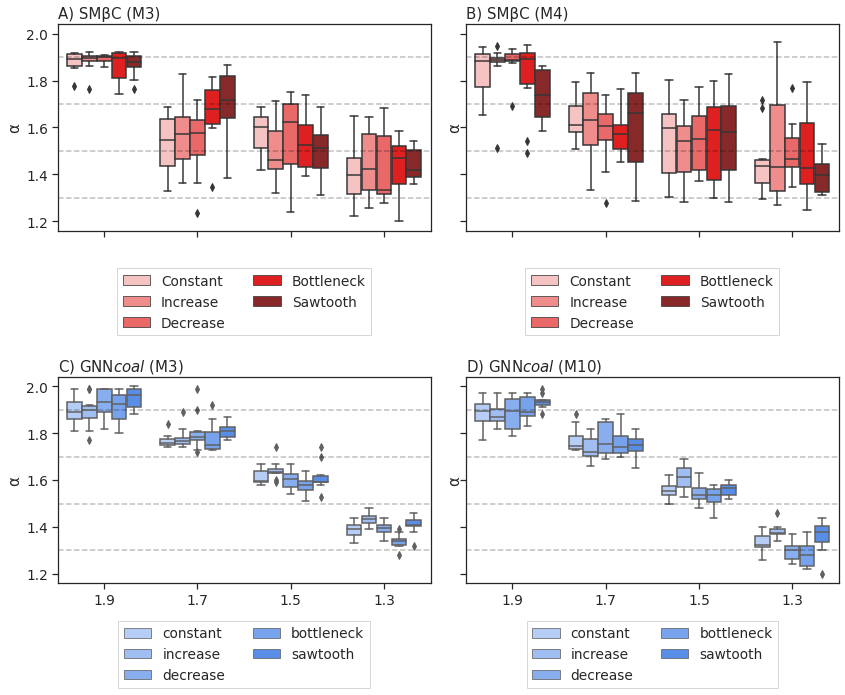

In [ ]:

sns.set(font_scale=1.25)
sns.set_style("ticks")
#sns.set_style("whitegrid")


fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)

ax = axs[0][0]
sns.boxplot(data=df[df["model"] == "SMβC-M3"], x="alpha", y="value", hue="demography", ax=ax, palette=["#ffbaba", "#ff7b7b", "#ff5252", "#ff0000", "#981919"]).set_title("A) SMβC (M3)", loc="left")
ax.set(xlabel="", ylabel="α")
ax.legend(loc='lower left')
ax.legend(loc='lower left')
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, ncol=2)
ax.axhline(y=1.9, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.7, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.5, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.3, c="black", alpha=0.25, linestyle="--")




ax = axs[0][1]
sns.boxplot(data=df[df["model"] == "SMβC-M4"], x="alpha", y="value", hue="demography", ax=ax, palette=["#ffbaba", "#ff7b7b", "#ff5252", "#ff0000", "#981919"]).set_title("B) SMβC (M4)", loc="left")
ax.set(xlabel="", ylabel="α")
ax.legend(loc='lower left')
ax.legend(loc='lower left')
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, ncol=2)
ax.axhline(y=1.9, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.7, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.5, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.3, c="black", alpha=0.25, linestyle="--")




ax = axs[1][0]
sns.boxplot(data=df[df["model"] == "GNN-M3"], x="alpha", y="value", hue="demography", ax=ax, palette=["#accbff", "#92bbff", "#78aaff", "#649eff", "#4188ff"]).set_title("C) GNN$\it{coal}$ (M3)", loc="left")
ax.set(xlabel="", ylabel="α")
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=2)
ax.axhline(y=1.9, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.7, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.5, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.3, c="black", alpha=0.25, linestyle="--")



ax = axs[1][1]
sns.boxplot(data=df[df["model"] == "GNN"], x="alpha", y="value", hue="demography", ax=ax, palette=["#accbff", "#92bbff", "#78aaff", "#649eff", "#4188ff"]).set_title("D) GNN$\it{coal}$ (M10)", loc="left")
ax.set(xlabel="", ylabel="α")
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=False, shadow=False, ncol=2)
ax.axhline(y=1.9, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.7, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.5, c="black", alpha=0.25, linestyle="--")
ax.axhline(y=1.3, c="black", alpha=0.25, linestyle="--")


plt.tight_layout()
plt.savefig("./figures/Figure_4.pdf", dpi=600)

# Figure 5: see directory mm-selection-classification

# Figure 6

In [ ]:
from os.path import basename



def convert_tree_sequence_to_data_object_alpha(tree_sequence: tskit.trees.TreeSequence,
                                                     alpha,
                                                     num_trees:int = 500,
                                                     num_embedding:int = 60, 
                           ):
    
    y = torch.Tensor([alpha])
    tree_sequence = reduce_tree_sequence(tree_sequence, 3)
    max_num_nodes = 2 * tree_sequence.num_samples - 1 
    data_objects = []
    
    for i, tree in enumerate(tree_sequence.trees()):
        if i < num_trees:
            
            data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
            rename_data_attribute(data, "branch_length", "edge_weight") 
            num_nodes = data.num_nodes
            data.x = torch.eye(max_num_nodes,num_embedding)
            data.x[num_nodes:] = torch.zeros(num_embedding)
            data.y = torch.Tensor(y)
            data.num_nodes = max_num_nodes
            data_objects.append(data)
            
        else: 
            break

    return data_objects

def get_tree_starting_positions(ts):
    tree_starting_positions = []
    for tree in ts.trees():
        left = tree.interval.left
        right = tree.interval.right
        tree_starting_positions.append(left)
    return tree_starting_positions

def ts_to_do(ts):
    
    #ts = reduce_tree_sequence(ts, 3)
    
    max_num_nodes = 2* ts.num_samples - 1
    num_embedding = 60
    data_objects = []
    trees = ts.trees()
    #trees = ts.aslist()
    for k, tree in enumerate(trees):
        data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
        rename_data_attribute(data, "branch_length", "edge_weight") 
        num_nodes = data.num_nodes
        data.x = torch.eye(max_num_nodes,num_embedding)
        data.x[num_nodes:] = torch.zeros(num_embedding)
        #data.y = torch.Tensor(y)
        data.num_nodes = max_num_nodes
        data_objects.append(data)
    return data_objects


def run_model(model, tss, batch_size=20):

    xs = []
    ys = []
    hue = []
    with torch.no_grad():
        for i, ts in enumerate(tqdm(tss)):            
            data_objects = ts_to_do(ts)
            dl = DataLoader(data_objects, batch_size=batch_size)
            y_hats = []
            last_digit = int(repr(len(data_objects))[-1])
            for batch in dl:
                
                if batch.num_nodes != 19:
                    batch = batch.to(device)
                    y_hat = model(batch)
                    y_hats += y_hat.T[0].detach().cpu().tolist()
                
            y = y_hats
            x = get_tree_starting_positions(ts)
            
            if batch.num_nodes != 19:
                xs += x
                ys += y
                hue += len(x) * [i]
            else:
                y = y[:-1]
                x = y[:-1]
                xs += x
                ys += y
                hue += len(x) * [i]
                
        d = pd.DataFrame([xs, ys, hue]).T
        d.columns = ["pos", "alpha", "hue"]
    return d


def prepare_windowrize_plotting(model_out_frame, step = 50000):
    starts = np.arange(0, 1_000_000, step)
    ends = np.arange(step, 1_000_000+step, step)
    alphas_mean = []
    alphas_std = []
    for i, start in enumerate(starts):
        a = model_out_frame[np.logical_and(model_out_frame.pos >= starts[i],  model_out_frame.pos < ends[i])].alpha
        alphas_mean.append(a.mean())
        alphas_std.append(a.std())
    d = pd.DataFrame([starts, alphas_mean, alphas_std]).T
    d.columns = ["x", "means", "stds"]
    return d




class AlphaInferenceModel(nn.Module):
    
    def __init__(self, DemographyNet, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, time_window//4)
        self.l3 = nn.Linear(time_window//4, 1)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l3(F.relu(self.l2(F.relu(self.l1(x)))))


    
    
    

In [ ]:
import msprime

tss_selection_coefficients = {}

selection_coefficients = [0.01, 0.001, 0.0001, 0]

sample_size=20
L = 1*10**6
r = 1e-8
Ne = (10**5)

for _, s in enumerate(selection_coefficients):
    
    tss = []
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    if s != 0:
        for x in range(0,10):
            ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,
                                    sequence_length=L,demography=demography,ploidy=1 ,
                                    model=[msprime.SweepGenicSelection(position=(L/2),
                                                                       start_frequency=(1/(Ne)),
                                                                       end_frequency=0.999,s=s,dt=1e-6),
                                           msprime.StandardCoalescent()], random_seed=((x+3)**2))
            ts = ts.simplify([0,2,4,6,8,10,12,14,16,18])
            tss.append(ts)
    else:
         for x in range(0,10):
            ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,
                                    sequence_length=L,demography=demography,ploidy=1 ,
                                    model=[msprime.StandardCoalescent()], random_seed=((x+3)**2))
            ts = ts.simplify([0,2,4,6,8,10,12,14,16,18])
            tss.append(ts)
    tss_selection_coefficients[s] = tss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
model_alpha_M10 = AlphaInferenceModel(demography_net).to(device)
model_path = "./trained_models/alpha_inf/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model_alpha_M10.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model_out_frame_0 = run_model(model_alpha_M10, tss_selection_coefficients[selection_coefficients[0]], batch_size=20)
model_out_frame_1 = run_model(model_alpha_M10, tss_selection_coefficients[selection_coefficients[1]], batch_size=20)
model_out_frame_2 = run_model(model_alpha_M10, tss_selection_coefficients[selection_coefficients[2]], batch_size=20)
model_out_frame_3 = run_model(model_alpha_M10, tss_selection_coefficients[selection_coefficients[3]], batch_size=20)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

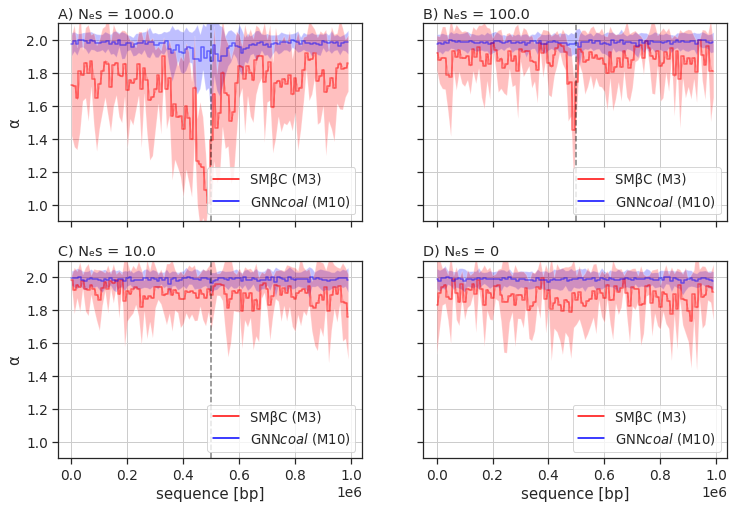

In [ ]:
sns.set(font_scale=1.25)
sns.set_style("ticks")


window = 10000
df_0 = prepare_windowrize_plotting(model_out_frame_0, step=window)
df_1 = prepare_windowrize_plotting(model_out_frame_1, step=window)
df_2 = prepare_windowrize_plotting(model_out_frame_2, step=window)
df_3 = prepare_windowrize_plotting(model_out_frame_3, step=window)

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
sns.set(style="ticks", font_scale=1.2)

ax = axs[0][0]
selection_coefficient = selection_coefficients[0]

y = pd.read_csv("./data/smbc2_sequence_alpha/Table_3_new_Kingman_M3_alpha_theta_4000_rho_1_s_0.01_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_0.columns = ["x", "alpha", "stds"]
df_0["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_0])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=False).set_title(label="A) Nₑs = " + str(selection_coefficient* Ne), loc="left")
#df_subset = df[df["model"]=="GNN"]
#ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)
ax.set(ylabel="α", xlabel="sequence [bp]")
ax.axvline(x=L/2, ls='--', alpha=0.5, color="black")
ax.legend(loc='lower right')
ax.grid(True)




ax = axs[0][1]
selection_coefficient = selection_coefficients[1]

y = pd.read_csv("data/smbc2_sequence_alpha/Table_3_new_Kingman_M3_alpha_theta_4000_rho_1_s_0.001_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_1.columns = ["x", "alpha", "stds"]
df_1["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_1])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=False).set_title(label="B) Nₑs = " + str(selection_coefficient* Ne), loc="left")
#df_subset = df[df["model"]=="GNN"]
#ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


ax.set(ylabel="α", xlabel="sequence [bp]")
ax.axvline(x=L/2, ls='--', alpha=0.5, color="black")
ax.legend(loc='lower right')
ax.grid(True)





ax = axs[1][0]
selection_coefficient = selection_coefficients[2]

y = pd.read_csv("data/smbc2_sequence_alpha/Table_3_new_Kingman_M3_alpha_theta_4000_rho_1_s_1e-04_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_2.columns = ["x", "alpha", "stds"]
df_2["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_2])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=False).set_title(label="C) Nₑs = " + str(selection_coefficient* Ne), loc="left")

#df_subset = df[df["model"]=="GNN"]
#ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)

ax.set(ylabel="α", xlabel="sequence [bp]")
ax.axvline(x=L/2, ls='--', alpha=0.5, color="black")
ax.legend(loc='lower right')
ax.grid(True)




ax = axs[1][1]
selection_coefficient = selection_coefficients[3]

y = pd.read_csv("data/smbc2_sequence_alpha/Table_3_new_Kingman_M3_alpha_theta_4000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_3.columns = ["x", "alpha", "stds"]
df_3["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_3])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=False).set_title(label="D) Nₑs = " + str(selection_coefficient* Ne), loc="left")
#df_subset = df[df["model"]=="GNN"]
#ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)

df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


ax.set(ylabel="α", xlabel="sequence [bp]")
ax.legend(loc='lower right')
ax.set(ylim=(0.9, 2.1))
ax.grid(True)

plt.savefig("./figures/Figure_6.pdf", dpi=600)

In [ ]:
sample_size=10
import msprime.cli as cli
mu=1*1e-8
beta_seq_alpha = {}
for L in [10**6]:#
    r=1
    r=mu*r
    for s in [0]:
        for alpha in [1.9, 1.7, 1.5, 1.3]:
            Ne=10**6
            demography=msprime.Demography()
            demography.add_population(initial_size=(Ne))
            tss = []
            for x in range(1,11):
                ts=msprime.sim_ancestry(samples=sample_size,recombination_rate=r,sequence_length=L,demography=demography,ploidy=1 ,model=[msprime.BetaCoalescent(alpha=alpha)],random_seed=((x*10+3)**2))
                tss.append(ts)
            beta_seq_alpha[alpha] = tss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
model_alpha_M10 = AlphaInferenceModel(demography_net).to(device)
model_path = "./trained_models/alpha_inf/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model_alpha_M10.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
bs = 20
model_out_frame_0 = run_model(model_alpha_M10, beta_seq_alpha[1.9], batch_size=bs)
model_out_frame_1 = run_model(model_alpha_M10, beta_seq_alpha[1.7], batch_size=bs)
model_out_frame_2 = run_model(model_alpha_M10, beta_seq_alpha[1.5], batch_size=bs)
model_out_frame_3 = run_model(model_alpha_M10, beta_seq_alpha[1.3], batch_size=bs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#

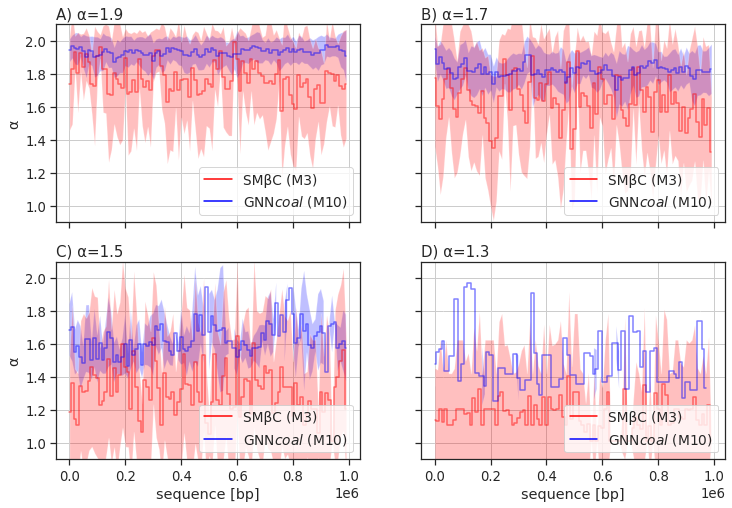

In [ ]:
window = 10000
df_0 = prepare_windowrize_plotting(model_out_frame_0, step=window)
df_1 = prepare_windowrize_plotting(model_out_frame_1, step=window)
df_2 = prepare_windowrize_plotting(model_out_frame_2, step=window)
df_3 = prepare_windowrize_plotting(model_out_frame_3, step=window)

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)

sns.set(font_scale=1.25)
sns.set_style("ticks")


ax = axs[0][0]

y = pd.read_csv("./data/smbc2_sequence_alpha/Table_3_beta_M3_alpha_1.9_theta_40000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_0.columns = ["x", "alpha", "stds"]
df_0["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_0])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=None).set_title(label="A) α=1.9", loc="left")

df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


ax.set(ylabel="α", xlabel="sequence [bp]")
ax.legend(loc='lower right')
ax.grid(True)




ax = axs[0][1]

y = pd.read_csv("./data/smbc2_sequence_alpha/Table_3_beta_M3_alpha_1.7_theta_40000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_1.columns = ["x", "alpha", "stds"]
df_1["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_1])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=None).set_title(label="B) α=1.7", loc="left")

df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


ax.set(ylabel="α", xlabel="sequence [bp]")
ax.legend(loc='lower right')
ax.grid(True)





ax = axs[1][0]
y = pd.read_csv("./data/smbc2_sequence_alpha/Table_3_beta_M3_alpha_1.5_theta_40000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_2.columns = ["x", "alpha", "stds"]
df_2["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_2])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=None).set_title(label="C) α=1.5", loc="left")

df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)

ax.set(ylabel="α", xlabel="sequence [bp]")
ax.legend(loc='lower right')
ax.grid(True)




ax = axs[1][1]

y = pd.read_csv("./data/smbc2_sequence_alpha/Table_3_beta_M3_alpha_1.3_theta_40000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = "SMβC (M3)"
df_3.columns = ["x", "alpha", "stds"]
df_3["model"] = "GNN$\it{coal}$ (M10)"
df = pd.concat([y, df_3])
df = df.reset_index()
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["red", "blue"], ci=None).set_title(label="D) α=1.3", loc="left")

df_subset = df[df["model"]=="GNN$\it{coal}$ (M10)"]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]=="SMβC (M3)"]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)

ax.set(ylabel="α", xlabel="sequence [bp]")
ax.legend(loc='lower right')
ax.set(ylim=(0.9, 2.1))
ax.grid(True)


plt.savefig("./figures/subfigure_alpha_along_sequence_beta.pdf", dpi=600)

In [ ]:
def discretize(value):
    if value < -1: return -1
    if value >= -1 and value < -1e-7: return 0
    if value >= -1e-7 and value < -1e-10: return 1
    if value >= -1e-10 and value < -1e-10: return 2
    if value >= -1e-10 and value < 1e-7: return 3
    if value >= 1e-7 and value <= 1: return 4
    if value > 1: return 5
    

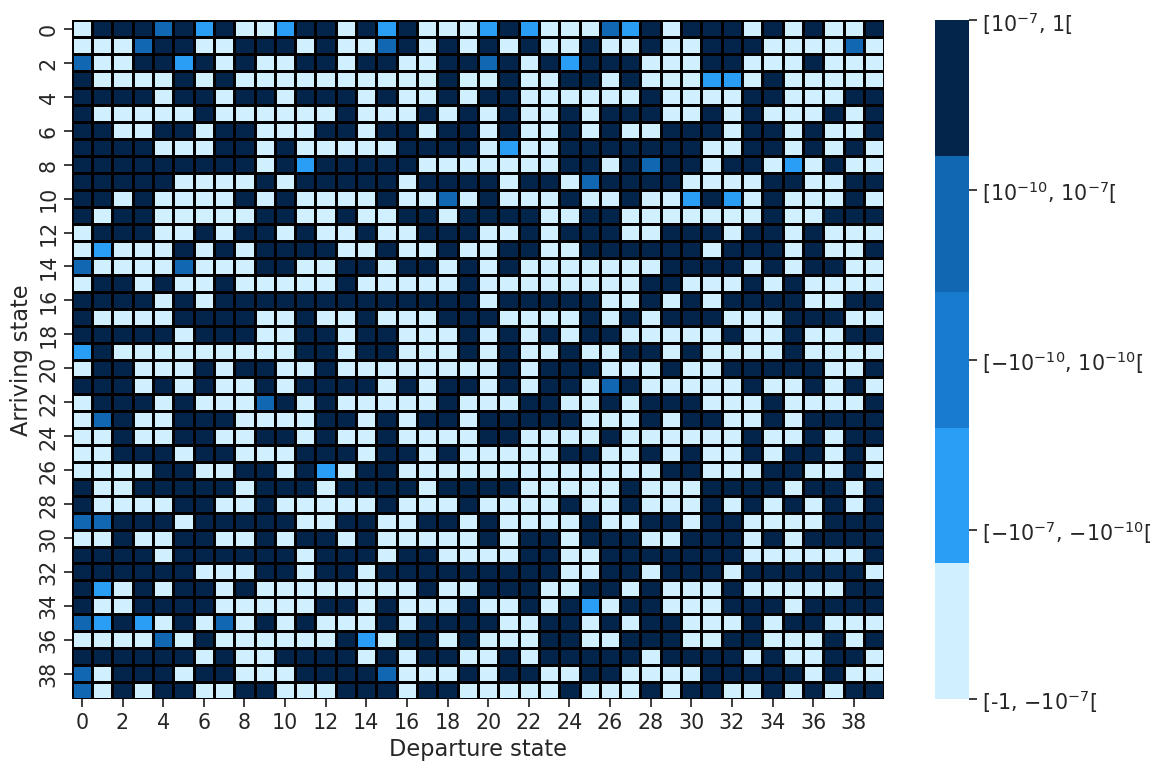

In [ ]:
states = pd.read_csv("./csvs/Sup_Figure_2_3_alpha1.99.csv").iloc[:,1:]
states=states.applymap(discretize)
states.columns = range(0,40)

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True)

myColors = ("#caf0f8","#90e0ef","#00b4d8","#0077b6","#03045e")
myColors = ("#d0efff","#2a9df4","#187bcd","#1167b1","#03254c")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

sns.heatmap(data=states, cmap=cmap,  linecolor='black', linewidths=1)#.set_title("Difference between observed and theoretical transition matrix")
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0,1,2,3, 4])
colorbar.set_ticklabels([r"[-1, $-10^{-7}$[", "[$-10^{-7}$, $-10^{-10}$[", "[$-10^{-10}$, $10^{-10}$[", "[$10^{-10}$, $10^{-7}$[", "[$10^{-7}$, 1["])

ax.set_ylabel('Arriving state')
ax.set_xlabel('Departure state')

plt.tight_layout()
plt.savefig("./figures/subfigure_2_fix.pdf", dpi=600)

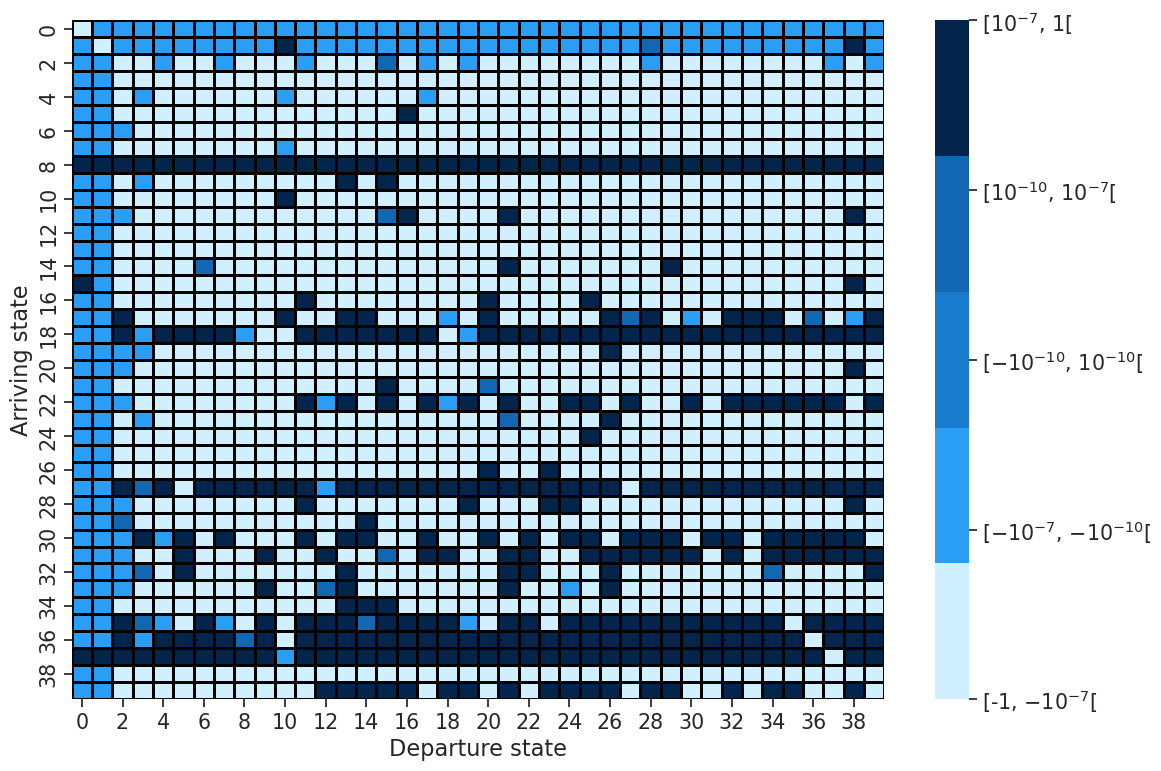

In [ ]:
states = pd.read_csv("./csvs/Sup_Figure_2_3_alpha1.3.csv").iloc[:,1:]
states=states.applymap(discretize)
states.columns = range(0,40)

from matplotlib.colors import LinearSegmentedColormap
fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True)

myColors = ("#caf0f8","#90e0ef","#00b4d8","#0077b6","#03045e")
myColors = ("#d0efff","#2a9df4","#187bcd","#1167b1","#03254c")
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

sns.heatmap(data=states, cmap=cmap,  linecolor='black', linewidths=1)#.set_title("Difference between observed and theoretical transition matrix")
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0,1,2,3, 4])
colorbar.set_ticklabels([r"[-1, $-10^{-7}$[", "[$-10^{-7}$, $-10^{-10}$[", "[$-10^{-10}$, $10^{-10}$[", "[$10^{-10}$, $10^{-7}$[", "[$10^{-7}$, 1["])

ax.set_ylabel('Arriving state')
ax.set_xlabel('Departure state')

plt.tight_layout()
plt.savefig("./figures/subfigure_3_fix.pdf", dpi=600)

# Figure 7

In [ ]:
gnn = "GNN$\it{coal}$ (M10)"
smbc_hue = "SMβC (M3)"

In [ ]:
from os.path import basename


class AlphaInferenceModel(nn.Module):
    
    def __init__(self, DemographyNet, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, time_window//4)
        self.l3 = nn.Linear(time_window//4, 1)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l3(F.relu(self.l2(F.relu(self.l1(x)))))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
alpha_model = AlphaInferenceModel(demography_net)
alpha_model = alpha_model.to(device)
criterion = RMSELoss
model_path = "./trained_models/alpha_inf/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
alpha_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
def ts_to_do(ts):
    
    #ts = reduce_tree_sequence(ts, 3)
    
    max_num_nodes = 2* ts.num_samples - 1
    num_embedding = 60
    data_objects = []
    trees = ts.trees()
    #trees = ts.aslist()
    for k, tree in enumerate(trees):
        data = from_networkx(nx.Graph(tree.as_dict_of_dicts()))
        rename_data_attribute(data, "branch_length", "edge_weight") 
        num_nodes = data.num_nodes
        data.x = torch.eye(max_num_nodes,num_embedding)
        data.x[num_nodes:] = torch.zeros(num_embedding)
        #data.y = torch.Tensor(y)
        data.num_nodes = max_num_nodes
        data_objects.append(data)
    return data_objects

def get_tree_starting_positions(ts):
    tree_starting_positions = []
    for tree in ts.trees():
        left = tree.interval.left
        right = tree.interval.right
        tree_starting_positions.append(left)
    return tree_starting_positions

def run_model(model, tss, batch_size=20):

    xs = []
    ys = []
    hue = []
    with torch.no_grad():
        for i, ts in enumerate(tqdm(tss)):
            data_objects = ts_to_do(ts)
            dl = DataLoader(data_objects, batch_size=batch_size)
            y_hats = []
            last_digit = int(repr(len(data_objects))[-1])
            for batch in dl:
                if batch.num_nodes != 19:
                    batch = batch.to(device)
                    y_hat = model(batch)
                    y_hats += y_hat.T[0].detach().cpu().tolist()
                
            y = y_hats
            x = get_tree_starting_positions(ts)
            
            if batch.num_nodes != 19:
                xs += x
                ys += y
                hue += len(x) * [i]
            else:
                y = y[:-1]
                x = y[:-1]
                xs += x
                ys += y
                hue += len(x) * [i]
                


        d = pd.DataFrame([xs, ys, hue]).T
        d.columns = ["pos", "alpha", "hue"]
        
    return d

def prepare_windowrize_plotting(model_out_frame, step = 50000):
    starts = np.arange(0, 1_000_000, step)
    ends = np.arange(step, 1_000_000+step, step)
    alphas_mean = []
    alphas_std = []
    for i, start in enumerate(starts):
        a = model_out_frame[np.logical_and(model_out_frame.pos >= starts[i],  model_out_frame.pos < ends[i])].alpha
        alphas_mean.append(a.mean())
        alphas_std.append(a.std())
    d = pd.DataFrame([starts, alphas_mean, alphas_std]).T
    d.columns = ["x", "means", "stds"]
    return d

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

<All keys matched successfully>

In [ ]:
tss, demography = simul_scenario()
model_out_frame_0 = run_model(alpha_model, tss)
demography_name = "data/partial_sawtooth"
tree_sequence_function = simul_scenario
tree_sequences, demography  = tree_sequence_function()
create_dataset(tree_sequences, demography, demography_name, all_trees=True)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

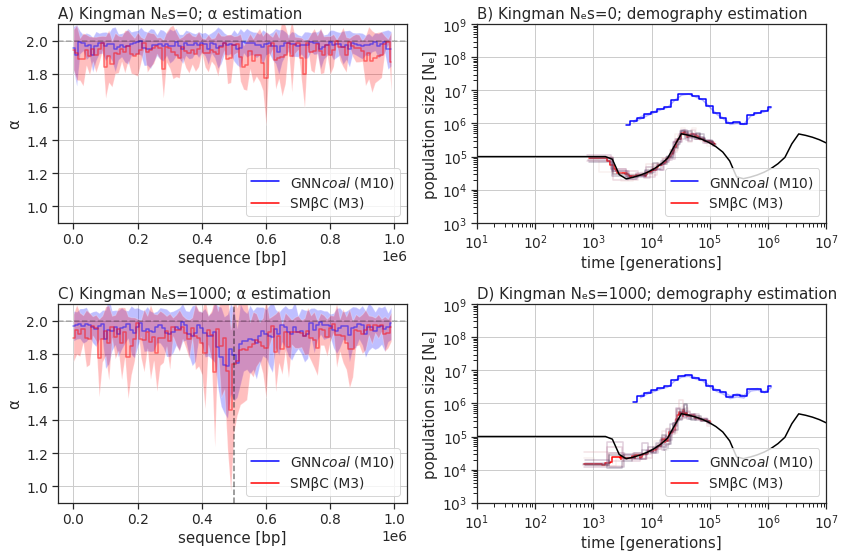

In [ ]:
path = Path("./data/smbc-data")
sns.set(font_scale=1.25, style="ticks")

fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=False, sharey=False)
ax = axs[0][0]
window = 10000

# GNN
df_0 = prepare_windowrize_plotting(model_out_frame_0, step=window)
df_0.columns = ["x", "alpha", "stds"]
df_0["model"] = gnn

# SMBC
y = pd.read_csv(path/"simul/Table_3_S_Kingman_M3_alpha_theta_4000_rho_1_s_0_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = smbc_hue


# combining both
df = pd.concat([df_0, y])
df = df.reset_index()

# just plotting the means
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["blue","red"], ci=None).set_title(label="A) Kingman Nₑs=0; α estimation", loc="left")


# plotting the standard deviation
df_subset = df[df["model"]==gnn]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]==smbc_hue]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


# axis labels
ax.set(ylabel="α", xlabel="sequence [bp]")
#ax.axvline(x=L/2, ls='--', alpha=0.5, color="black")
ax.legend(loc='lower right')
ax.set(ylim=(0.9, 2.1))
ax.axhline(y=2.0, c="black", alpha=0.25, linestyle="--")
ax.grid(True)




ax = axs[0][1]
x = path/("./simul/Table_3_S_Kingman_M3_Tc_s_0_.csv")
y = path/("./simul/Table_3_S_Kingman_M3_pop_s_0_.csv")
df0 = smbc_to_plotable_df(x=x, y=y)
df0 = df0[["time_rm", "population_size_rm", "population_size_rstd", "population_size", "time", "replicates"]]
df0["model"] = smbc_hue
df1 = pd.DataFrame([times_k, sizes_k]).T
df1.columns = ["time", "population_size"]
df1["model"] = gnn
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()
sns.lineplot(data=df01[df01["model"]==gnn], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["blue"])

sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black").set_title("B) Kingman Nₑs=0; demography estimation", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]", xscale="log", yscale="log", ylim=(1000, 1000_000_000), xlim=(10, 10_000_000))
ax.legend(loc='lower right')
ax.grid(True)

plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)


tss, demography = simul_selection_scenario()
model_out_frame_0 = run_model(alpha_model, tss, 20)


demography_name = "data/partial_sawtooth"
tree_sequence_function = simul_selection_scenario


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

tree_sequences, demography  = tree_sequence_function()
create_dataset(tree_sequences, demography, demography_name, all_trees=True)
dataset, _ = get_train_test_dataset("./" + demography_name + "/", split=1)
times_k, sizes_k, utimes_k, usizes_k = get_xy_variable(dataset)
utimes_k, usizes_k = remove_low_prediction(utimes_k, usizes_k)
times_k, sizes_k = remove_low_prediction(times_k, sizes_k)



path = Path("./data/smbc-data")
L = 1000000

ax = axs[1][0]
window = 10000

# GNN
df_0 = prepare_windowrize_plotting(model_out_frame_0, step=window)
df_0.columns = ["x", "alpha", "stds"]
df_0["model"] = gnn

# SMBC
y = pd.read_csv(path/"simul/Table_3_S_Kingman_M3_alpha_theta_4000_rho_1_s_0.01_.csv").iloc[:,1:]
smbc_stds = np.array(y.std(0).tolist())
smbc_means = np.array(y.mean(0).tolist())
y = y.melt()
y["x"] = np.repeat(list(np.array(list(range(100)))*10000), 10)
y.columns = ["variable", "alpha", "x"]
y["model"] = smbc_hue


# combining both
df = pd.concat([df_0, y])
df = df.reset_index()

# just plotting the means
sns.lineplot(data=df, x="x", y="alpha", hue="model", alpha=0.5, ax=ax, drawstyle='steps-mid', palette=["blue", "red"], ci=None).set_title(label="C) Kingman Nₑs=1000; α estimation", loc="left")


# plotting the standard deviation
df_subset = df[df["model"]==gnn]
ax.fill_between(df_subset["x"], df_subset["alpha"]+df_subset["stds"], df_subset["alpha"]-df_subset["stds"], facecolor='blue', alpha=0.25)
df_subset = df[df["model"]==smbc_hue]
ax.fill_between(np.array(list(range(100)))*10000, smbc_means+smbc_stds, smbc_means-smbc_stds, facecolor='red', alpha=0.25)


# axis labels
ax.set(ylabel="α", xlabel="sequence [bp]")
ax.axvline(x=L/2, ls='--', alpha=0.5, color="black")
ax.legend(loc='lower right')
ax.set(ylim=(0.9, 2.1))
ax.axhline(y=2.0, c="black", alpha=0.25, linestyle="--")
ax.grid(True)




ax = axs[1][1]
x = path/("./simul/Table_3_S_Kingman_M3_Tc_s_0.01_.csv")
y = path/("./simul/Table_3_S_Kingman_M3_pop_s_0.01_.csv")
df0 = smbc_to_plotable_df(x=x, y=y)
df0 = df0[["time_rm", "population_size_rm", "population_size_rstd", "population_size", "time", "replicates"]]
df0["model"] = smbc_hue

df1 = pd.DataFrame([times_k, sizes_k]).T
df1.columns = ["time", "population_size"]
df1["model"] = gnn
df01 = pd.concat([df0, df1])
df01 = df01.reset_index()
sns.lineplot(data=df01[df01["model"]==gnn], x="time", y="population_size", hue="model", drawstyle='steps-mid', ax=ax, palette=["blue"])
sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
sns.lineplot(x=population_time, y=demography, ax=ax, color="black").set_title("D) Kingman Nₑs=1000; demography estimation", loc="left")
ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]", xscale="log", yscale="log", ylim=(1000, 1000_000_000), xlim=(10, 10_000_000))
ax.legend(loc='lower right')
ax.grid(True)


plt.axvline(x=10, color='k', linestyle='--')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/Figure_7_all_trees.pdf", dpi=600)

In [ ]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## ARGWeaver

In [ ]:
from IPython.display import SVG
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from copy import deepcopy
import os
import pickle
from Bio import Phylo

In [ ]:
def kingman_sawtooth(Ne=10**4, L=20_000_000):
    sample_size = 100
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 


def kingman_constant(Ne=10**4, L=20_000_000):
    sample_size = 100
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    db = msprime.DemographyDebugger(demography=demography)
    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

def kingman_bottleneck(Ne=10**4, L=30_000_000):
    sample_size = 100
    r = 1e-8
    alpha = 2.0
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=1000, growth_rate=0, initial_size=Ne/10)
    demography.add_population_parameters_change(time=10000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography)

    tree_sequences = []
    for x in range(1,11):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1,random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

In [ ]:
def sawtooth(alpha, replicates=10, Ne = 10**6):
    sample_size = 100
    #L = 10**8
    L = 3_000_000
    r = 1e-8
    
    demography=msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None, growth_rate=6437.7516497364/(4*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(4*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(4*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(4*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(4*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(4*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0, initial_size=Ne)
    db = msprime.DemographyDebugger(demography=demography,model=msprime.BetaCoalescent(alpha=alpha))
    tree_sequences = []
    for x in range(1,replicates+1):
        ts=msprime.sim_ancestry(samples=sample_size,
                                recombination_rate=r,
                                sequence_length=L,
                                demography=demography,ploidy=1 ,model=msprime.BetaCoalescent(alpha=alpha),random_seed=((alpha*x+1)**2))
        tree_sequences.append(ts)
    demography = db.population_size_trajectory(population_time).flatten()
    return list(tree_sequences), demography 

In [ ]:
_, demography = kingman_sawtooth()
_, demography = sawtooth(1.9)

In [ ]:
def reduce_tree_sequence(ts, num_samples):
    return ts.simplify(np.random.choice(range(ts.num_samples), num_samples, replace=False).tolist())

In [ ]:
def get_inferred_tss(tss, Ne = 5_000):
    inferred_tss = []
    for ts in tqdm(tss):
        ts = msprime.mutate(ts, rate=1e-8)
        sample_data = tsinfer.SampleData.from_tree_sequence(ts, path="inf-arg.samples", num_flush_threads=10)
        ts = tsinfer.infer(sample_data, recombination_rate=1e-8)
        ts = ts.simplify()
        
        priors_moretimes = tsdate.build_prior_grid(ts, Ne, timepoints=150)
        dated_ts = tsdate.date(ts, mutation_rate=1e-7, priors=priors_moretimes, ignore_oldest_root=True)
        inferred_tss.append(dated_ts)

    inferred_downsampled_tss = []
    for ts in inferred_tss:
        inferred_downsampled_ts = reduce_tree_sequence(ts, 10)
        inferred_downsampled_tss.append(inferred_downsampled_ts)

    #inferred_tss = inferred_downsampled_tss
    return inferred_downsampled_tss

def datatize_trees(trees: list[tskit.trees.Tree]):
    data_objects = [from_networkx(nx.Graph(tree.as_dict_of_dicts())) for tree in trees if len(list(tree.nodes())) >= 10]
    return data_objects
    
def datatize_trees(trees: list[tskit.trees.Tree]):
    data_objects = [from_networkx(nx.Graph(tree.as_dict_of_dicts())) for tree in trees]
    #for data in data_objects: rename_data_attribute(data, "branch_length", "edge_weight")
    return data_objects

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffPoolNet(19, 60, 192, 60).to(device)
model.load_state_dict(torch.load("./trained_models/demography_models/mmc_diffpool_model_demography_inference_intermediate1_1000000.pth"))

<All keys matched successfully>

In [ ]:
/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs19

'/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis'

In [ ]:
dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs19/"

population_time_shorts_rep = []
y_hat_shorts_rep = []

for rep in [0, 1, 2, 3, 4 ,5, 6, 7, 8, 9]:

    population_time_shorts = []
    y_hat_shorts = []

    for mcmc_reps in range(1):
        try:
            data_objects = []
            files = os.listdir(dir)
            np.random.shuffle(files)
            
            #idxs = np.argsort([int(file.split("_")[2]) for file in files])
            #files = np.array(files)[idxs][::1].tolist()

            for i, file in enumerate(files):
                if "beta" in file and "rep" + str(rep) in file:
                    with open(dir + file, 'rb') as handle:
                        graph = pickle.load(handle)
                        data_objects.append(from_networkx(graph))


            data_objects = data_objects[:1000]
            
            node_times = []
            for d in data_objects:
                node_times += d.weight.tolist()
            
            x_times_std = 1.5
            log_node_times = np.log(node_times)
            mean = log_node_times.mean()
            std = log_node_times.std()
            lowerbound = np.exp(mean-x_times_std*std)
            upperbound = np.exp(mean+x_times_std*std)
            mask1 = population_time > lowerbound
            mask2 = population_time < upperbound
            mask = np.logical_and(mask1, mask2)
            

            num_embedding = 60
            max_num_nodes = 19
            for _ , data in enumerate(data_objects):
                num_nodes = data.num_nodes
                data.x = torch.eye(max_num_nodes,num_embedding)
                data.x[num_nodes:] = torch.zeros(num_embedding)
                data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                data.num_nodes = max_num_nodes

            y_true, y_hat, mask = pass_one_data_point((data_objects, mask)) 
            y_hat = y_hat.cpu()
            y_hat = np.exp(y_hat)
            y_hat = y_hat * mask
            y_hat = y_hat.mean(0)

            print(len(data_objects))

            population_time_short = population_time*mask[0].tolist()
            y_hat_short = np.array(y_hat*mask[0]).tolist()
            population_time_short = [t for t in population_time_short if t != 0]
            y_hat_short = [y for y in y_hat_short if y != 0]

            y_hat_shorts.append(y_hat_short)
            population_time_shorts.append(population_time_short)
        except Exception as e:
            print(e, rep, mcmc_reps)
    
    population_time_shorts_rep.append(population_time_shorts)
    y_hat_shorts_rep.append(y_hat_shorts)
    
population_time_shorts_rep_19 = population_time_shorts_rep
y_hat_shorts_rep_19 = y_hat_shorts_rep

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [ ]:
dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs17/"


population_time_shorts_rep = []
y_hat_shorts_rep = []

for rep in [0, 1, 2, 3,4 ,5, 6, 7, 8, 9]:

    population_time_shorts = []
    y_hat_shorts = []

    for mcmc_reps in range(1):
        try:
            data_objects = []


            files = os.listdir(dir)
            np.random.shuffle(files)
            
            #idxs = np.argsort([int(file.split("_")[2]) for file in files])
            #files = np.array(files)[idxs][::1].tolist()

            for i, file in enumerate(files):
                if "beta" in file and "rep" + str(rep) in file:
                    with open(dir + file, 'rb') as handle:
                        graph = pickle.load(handle)
                        data_objects.append(from_networkx(graph))


            data_objects = data_objects[:1000]
            
            node_times = []
            for d in data_objects:
                node_times += d.weight.tolist()
            
            x_times_std = 1.5
            log_node_times = np.log(node_times)
            mean = log_node_times.mean()
            std = log_node_times.std()
            lowerbound = np.exp(mean-x_times_std*std)
            upperbound = np.exp(mean+x_times_std*std)
            mask1 = population_time > lowerbound
            mask2 = population_time < upperbound
            mask = np.logical_and(mask1, mask2)
            

            num_embedding = 60
            max_num_nodes = 19
            for _ , data in enumerate(data_objects):
                num_nodes = data.num_nodes
                data.x = torch.eye(max_num_nodes,num_embedding)
                data.x[num_nodes:] = torch.zeros(num_embedding)
                data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                data.num_nodes = max_num_nodes
                data.edge_weight = data.weight

            y_true, y_hat, mask = pass_one_data_point((data_objects, mask)) 
            y_hat = y_hat.cpu()
            y_hat = np.exp(y_hat)
            y_hat = y_hat * mask
            y_hat = y_hat.mean(0)

            print(len(data_objects))

            population_time_short = population_time*mask[0].tolist()
            y_hat_short = np.array(y_hat*mask[0]).tolist()
            population_time_short = [t for t in population_time_short if t != 0]
            y_hat_short = [y for y in y_hat_short if y != 0]

            y_hat_shorts.append(y_hat_short)
            population_time_shorts.append(population_time_short)
        except Exception as e:
            print(e, rep, mcmc_reps)
    
    population_time_shorts_rep.append(population_time_shorts)
    y_hat_shorts_rep.append(y_hat_shorts)
    
population_time_shorts_rep_17 = population_time_shorts_rep
y_hat_shorts_rep_17 = y_hat_shorts_rep

1000
1000
1000
1000
1000
1000
1000
1000
592
1000


In [ ]:
dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs15/"


population_time_shorts_rep = []
y_hat_shorts_rep = []

for rep in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    population_time_shorts = []
    y_hat_shorts = []

    for mcmc_reps in range(1):
        try:
            data_objects = []


            files = os.listdir(dir)
            
            np.random.shuffle(files)
            
            #idxs = np.argsort([int(file.split("_")[2]) for file in files])
            #files = np.array(files)[idxs][::1].tolist()

            for i, file in enumerate(files):
                if "beta" in file and "rep" + str(rep) in file:
                    with open(dir + file, 'rb') as handle:
                        graph = pickle.load(handle)
                        data_objects.append(from_networkx(graph))


            data_objects = data_objects[:1000]
            
            node_times = []
            for d in data_objects:
                node_times += d.weight.tolist()
            
            x_times_std = 1.5
            log_node_times = np.log(node_times)
            mean = log_node_times.mean()
            std = log_node_times.std()
            lowerbound = np.exp(mean-x_times_std*std)
            upperbound = np.exp(mean+x_times_std*std)
            mask1 = population_time > lowerbound
            mask2 = population_time < upperbound
            mask = np.logical_and(mask1, mask2)
            

            num_embedding = 60
            max_num_nodes = 19
            for _ , data in enumerate(data_objects):
                num_nodes = data.num_nodes
                data.x = torch.eye(max_num_nodes,num_embedding)
                data.x[num_nodes:] = torch.zeros(num_embedding)
                data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                data.num_nodes = max_num_nodes
                data.edge_weight = data.weight

            y_true, y_hat, mask = pass_one_data_point((data_objects, mask)) 
            y_hat = y_hat.cpu()
            y_hat = np.exp(y_hat)
            y_hat = y_hat * mask
            y_hat = y_hat.mean(0)

            print(len(data_objects))

            population_time_short = population_time*mask[0].tolist()
            y_hat_short = np.array(y_hat*mask[0]).tolist()
            population_time_short = [t for t in population_time_short if t != 0]
            y_hat_short = [y for y in y_hat_short if y != 0]

            y_hat_shorts.append(y_hat_short)
            population_time_shorts.append(population_time_short)
        except Exception as e:
            print(e, rep, mcmc_reps)
    
    population_time_shorts_rep.append(population_time_shorts)
    y_hat_shorts_rep.append(y_hat_shorts)
    
population_time_shorts_rep_15 = population_time_shorts_rep
y_hat_shorts_rep_15 = y_hat_shorts_rep

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [ ]:
#dir = "/home/anon/projects2/weaving_an_arg/graphs13/"
dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs13/"


population_time_shorts_rep = []
y_hat_shorts_rep = []

for rep in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    population_time_shorts = []
    y_hat_shorts = []

    for mcmc_reps in range(1):
        try:
            data_objects = []


            files = os.listdir(dir)
            
            np.random.shuffle(files)
            
            #idxs = np.argsort([int(file.split("_")[2]) for file in files])
            #files = np.array(files)[idxs][::1].tolist()

            for i, file in enumerate(files):
                if "beta" in file and "rep" + str(rep) in file:
                    with open(dir + file, 'rb') as handle:
                        graph = pickle.load(handle)
                        data_objects.append(from_networkx(graph))


            data_objects = data_objects[:1000]
            
            node_times = []
            for d in data_objects:
                node_times += d.weight.tolist()
            
            x_times_std = 1.5
            log_node_times = np.log(node_times)
            mean = log_node_times.mean()
            std = log_node_times.std()
            lowerbound = np.exp(mean-x_times_std*std)
            upperbound = np.exp(mean+x_times_std*std)
            mask1 = population_time > lowerbound
            mask2 = population_time < upperbound
            mask = np.logical_and(mask1, mask2)
            

            num_embedding = 60
            max_num_nodes = 19
            for _ , data in enumerate(data_objects):
                num_nodes = data.num_nodes
                data.x = torch.eye(max_num_nodes,num_embedding)
                data.x[num_nodes:] = torch.zeros(num_embedding)
                data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                data.num_nodes = max_num_nodes
                data.edge_weight = data.weight

            y_true, y_hat, mask = pass_one_data_point((data_objects, mask)) 
            y_hat = y_hat.cpu()
            y_hat = np.exp(y_hat)
            y_hat = y_hat * mask
            y_hat = y_hat.mean(0)

            print(len(data_objects))

            population_time_short = population_time*mask[0].tolist()
            y_hat_short = np.array(y_hat*mask[0]).tolist()
            population_time_short = [t for t in population_time_short if t != 0]
            y_hat_short = [y for y in y_hat_short if y != 0]

            y_hat_shorts.append(y_hat_short)
            population_time_shorts.append(population_time_short)
        except Exception as e:
            print(e, rep, mcmc_reps)
    
    population_time_shorts_rep.append(population_time_shorts)
    y_hat_shorts_rep.append(y_hat_shorts)
    
y_hat_shorts_rep_13 = y_hat_shorts_rep
population_time_shorts_rep_13 = population_time_shorts_rep 

1000
1000
batch_size should be a positive integer value, but got batch_size=0 2 0


/tmp/ipykernel_232030/2224377163.py:40: RuntimeWarning: Mean of empty slice.
  mean = log_node_times.mean()
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1000
792
1000
1000
1000
1000
1000


/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/

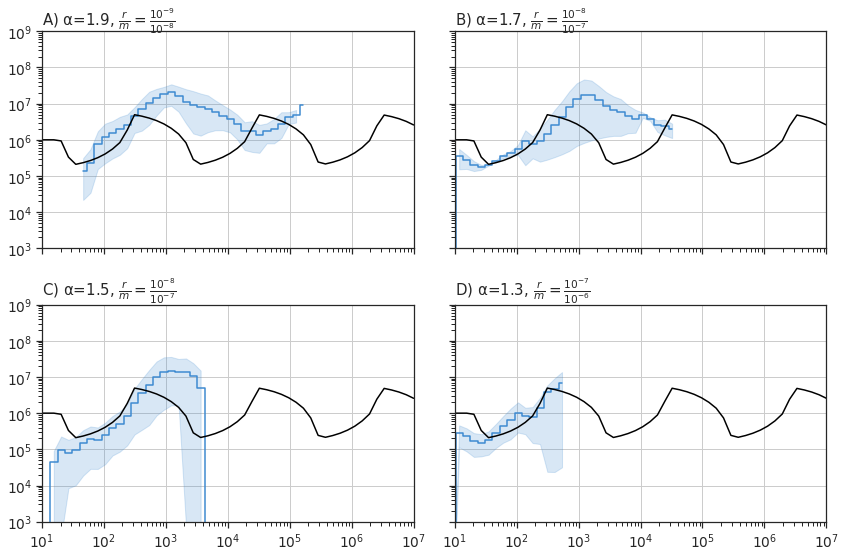

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-9}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-8}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-7}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth.pdf", dpi=600)

/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/

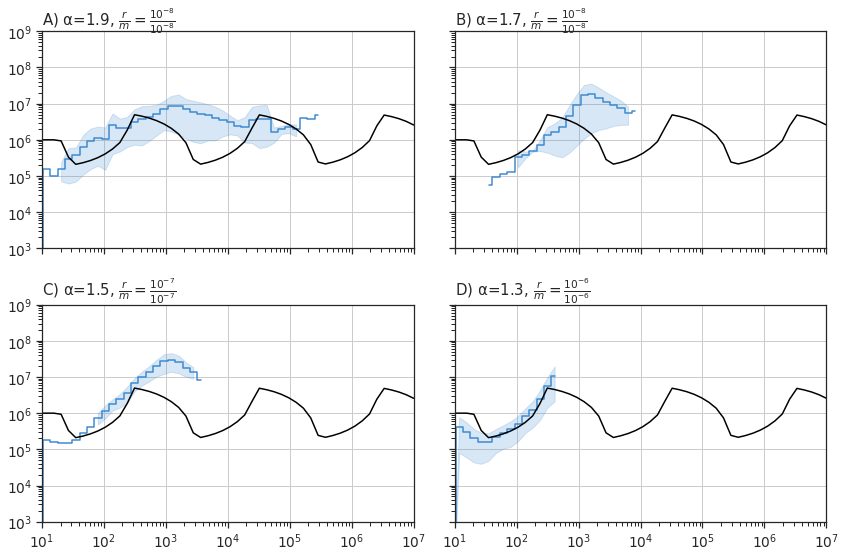

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-7}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-6}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth_rt1.pdf", dpi=600)

/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


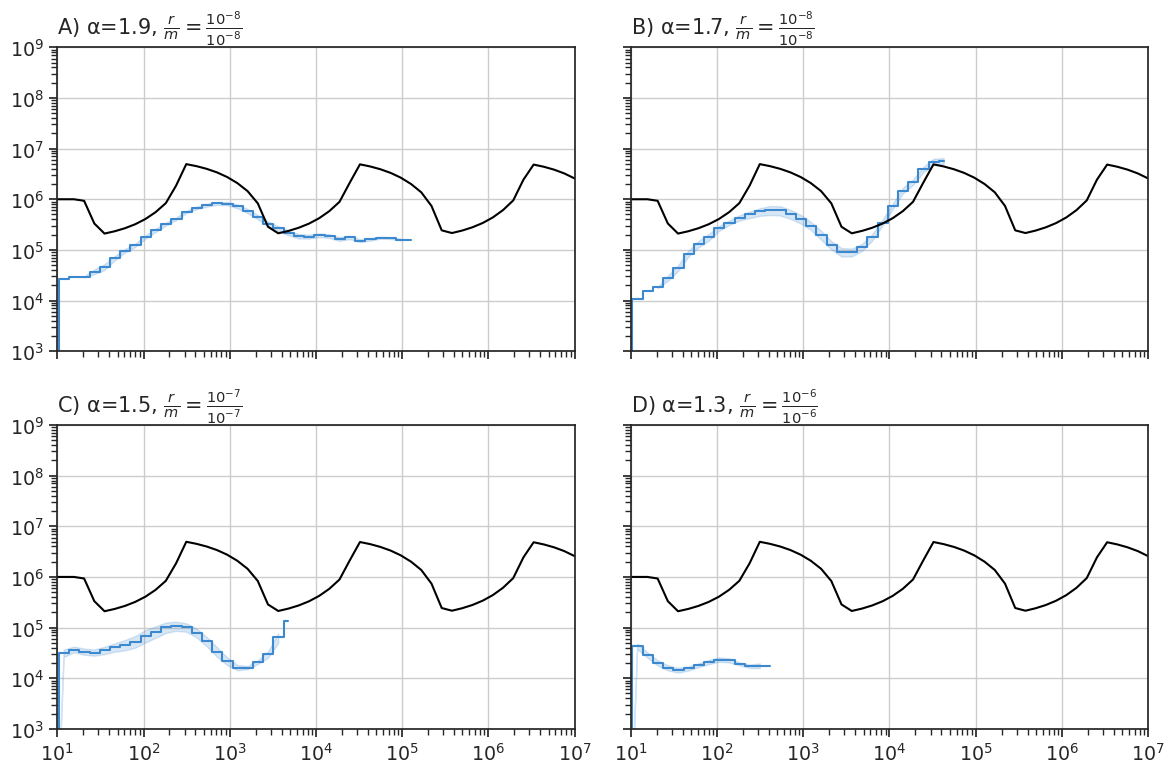

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-7}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-6}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth_rt1_fix.pdf", dpi=600)

/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


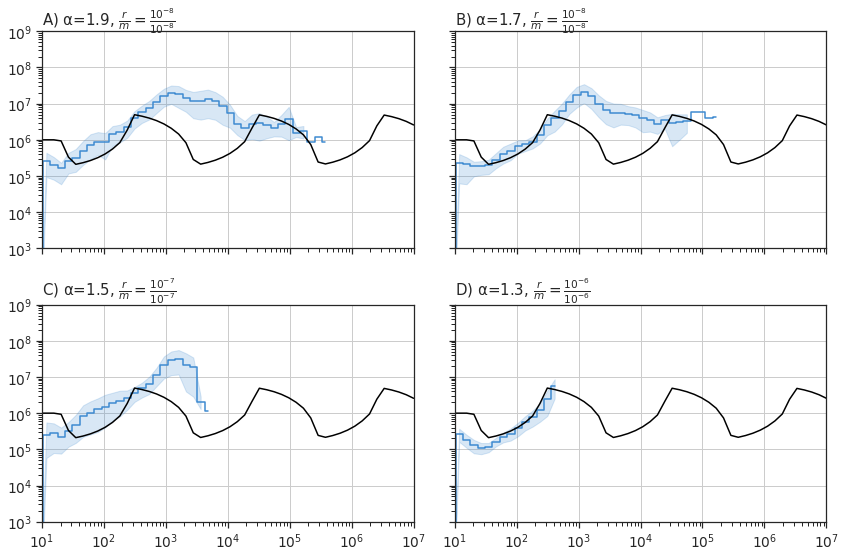

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-7}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-6}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth_rt1.pdf", dpi=600)

In [ ]:
def infer_alpha(dataset):
    y_trues = []
    y_hats = []
    with torch.no_grad():
        bs = 500
        for i, (data_objects, mask) in enumerate(dataset):
            if len(data_objects) == 1:
                data_objects.append(data_objects[0])
            dl = DataLoader(data_objects, batch_size=len(data_objects))
            for batch in dl:
                batch = batch.to(device)
                y_hat = model(batch)
                y_hat = np.mean(y_hat.cpu().numpy())
                y_hat = np.round(y_hat, 2).item()
                y_hats.append(y_hat)
    return y_hats



class AlphaInferenceModel(nn.Module):
    
    def __init__(self, DemographyNet, time_window=60):
        super().__init__()
        self.l1 = nn.Linear(time_window, time_window//2)
        self.l2 = nn.Linear(time_window//2, time_window//4)
        self.l3 = nn.Linear(time_window//4, 1)
        self.DemographyNet = DemographyNet
    
    def forward(self, batch):
        x = self.DemographyNet(batch)
        return self.l3(F.relu(self.l2(F.relu(self.l1(x)))))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
demography_net = DiffPoolNet(19, 60, 192, 60, track_running_stats=False)
model = AlphaInferenceModel(demography_net)
model_path = "./trained_models/alpha_inf/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model_path = "./trained_models/alpha_inf_M3/mmc_diffpool_model_alpha_inference_intermediate0_100000.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
np.random.seed(1111)
y_hats_a = {9:[], 7:[], 5:[], 3:[]}

for a in [9, 7, 5, 3]: #9, 7, 5, 3
    dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs1" + str(a) + "/"
    population_time_shorts_rep = []
    y_hat_shorts_rep = []
    y_trues = []
    y_hats = []
    for rep in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        population_time_shorts = []
        y_hat_shorts = []
        for mcmc_reps in [1000]:
            try:
                data_objects = []
                files = os.listdir(dir)
                #np.random.shuffle(files)
                for i, file in enumerate(files):
                    if "beta" in file and "rep" + str(rep) in file:
                        with open(dir + file, 'rb') as handle:
                            graph = pickle.load(handle)
                            data_objects.append(from_networkx(graph))
                data_objects = data_objects[:1000]
                num_embedding = 60
                max_num_nodes = 19
                for _ , data in enumerate(data_objects):
                    num_nodes = data.num_nodes
                    data.edge_weight = data.weight
                    data.x = torch.eye(max_num_nodes,num_embedding)
                    data.x[num_nodes:] = torch.zeros(num_embedding)
                    data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                    data.num_nodes = max_num_nodes
                with torch.no_grad():
                    dl = DataLoader(data_objects, batch_size=len(data_objects))
                    for batch in dl:
                        #batch = batch.to(device)
                        y_hat = model(batch)
                        y_hat = np.mean(y_hat.cpu().numpy())
                        y_hat = np.round(y_hat, 2).item()
                        y_hats.append(y_hat)
                print(a, np.mean(y_hats))
                y_hats_a[a].append(np.mean(y_hats))
            except Exception as e:
                print(e, rep, mcmc_reps)

9 1.7200000286102295
9 1.3899999856948853
9 1.5766666730244954
9 1.5600000023841858
9 1.522000002861023
9 1.5083333452542622
9 1.5671428612300329
9 1.532499998807907
9 1.5511111153496637
9 1.5990000009536742
7 1.9800000190734863
7 1.8050000071525574
7 1.696666677792867
7 1.6924999952316284
7 1.6899999856948853
7 1.6299999952316284
7 1.6485714231218611
7 1.6799999922513962
7 1.6066666576597426
7 1.5759999871253967
5 1.440000057220459
5 1.5600000023841858
5 1.6699999968210857
5 1.6624999940395355
5 1.6799999952316285
5 1.6183333198229473
5 1.6228571278708321
5 1.637499988079071
5 1.6022222174538507
5 1.575
3 1.4299999475479126
3 1.2949999570846558
batch_size should be a positive integer value, but got batch_size=0 2 1000
3 1.209999958674113
3 1.2724999785423279
3 1.233999991416931
3 1.2666666507720947
3 1.297142846243722
3 1.3387499898672104
3 1.3288888798819647


In [ ]:
for a in [9, 7, 5, 3]:
    if a == 3:
        x = np.array(y_hats_a[a])
        x = x[~np.isnan(x)]
        print(a, np.mean(x), np.std(x))
    else:
        x = y_hats_a[a]
        print(a,  np.mean(x), np.std(x))

9 2.0514380461829047 0.00495001990187107
7 1.9971539427884042 0.058168068907564964
5 1.9592178249027992 0.04170069102401567
3 1.7790378932441984 0.07903964742696512


In [ ]:
for a in [9, 7, 5, 3]:
    if a == 3:
        x = np.array(y_hats_a[a])
        x = x[~np.isnan(x)]
        print(a, np.mean(x), np.std(x))
    else:
        x = y_hats_a[a]
        print(a,  np.mean(x), np.std(x))

9 1.5526754014170359 0.0779499970729384
7 1.700540474033545 0.11028212363682405
5 1.6068412698923595 0.06695740890659656
3 1.2969942444478815 0.06102034272759868


In [ ]:
# corrected m10
np.random.seed(1111)
y_hats_a = {9:[], 7:[], 5:[], 3:[]}

for a in [9, 7, 5, 3]: #9, 7, 5, 3
    dir = "/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis/argweaver-analysis-withdata/graphs1" + str(a) + "/"
    population_time_shorts_rep = []
    y_hat_shorts_rep = []
    y_trues = []
    y_hats = []
    for rep in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        population_time_shorts = []
        y_hat_shorts = []
        for mcmc_reps in [1000]:
            try:
                data_objects = []
                files = os.listdir(dir)
                #np.random.shuffle(files)
                for i, file in enumerate(files):
                    if "beta" in file and "rep" + str(rep) in file:
                        with open(dir + file, 'rb') as handle:
                            graph = pickle.load(handle)
                            data_objects.append(from_networkx(graph))
                data_objects = data_objects[:1000]
                num_embedding = 60
                max_num_nodes = 19
                for _ , data in enumerate(data_objects):
                    num_nodes = data.num_nodes
                    data.edge_weight = data.weight
                    data.x = torch.eye(max_num_nodes,num_embedding)
                    data.x[num_nodes:] = torch.zeros(num_embedding)
                    data.y = torch.Tensor(torch.log(torch.Tensor([0]*60)))
                    data.num_nodes = max_num_nodes
                with torch.no_grad():
                    dl = DataLoader(data_objects, batch_size=len(data_objects))
                    for batch in dl:
                        #batch = batch.to(device)
                        y_hat = model(batch)
                        y_hat = np.mean(y_hat.cpu().numpy())
                        y_hat = np.round(y_hat, 2).item()
                        y_hats.append(y_hat)
                print(a, np.mean(y_hats))
                y_hats_a[a].append(np.mean(y_hats))
            except Exception as e:
                print(e, rep, mcmc_reps)

9 1.9800000190734863
9 1.9800000190734863
9 1.9833333492279053
9 1.9825000166893005
9 1.9820000171661376
9 1.9816666841506958
9 1.981428589139666
9 1.9812500178813934
9 1.9822222391764324
9 1.9820000171661376
7 1.9800000190734863
7 1.9850000143051147
7 1.9800000190734863
7 1.9825000166893005
7 1.9800000190734863
7 1.9800000190734863
7 1.981428589139666
7 1.9812500178813934
7 1.9822222391764324
7 1.9820000171661376
5 1.9700000286102295
5 1.965000033378601
5 1.9666666984558105
5 1.965000033378601
5 1.9660000324249267
5 1.9666666984558105
5 1.96857145854405
5 1.9662500321865082
5 1.9677778085072835
5 1.9680000305175782
3 1.7300000190734863
3 1.7450000047683716
batch_size should be a positive integer value, but got batch_size=0 2 1000
3 1.7900000015894573
3 1.7874999940395355
3 1.7859999895095826
3 1.7933333317438762
3 1.8057142836706979
3 1.8087500035762787
3 1.813333339161343


In [ ]:
for a in [9, 7, 5, 3]:
    if a == 3:
        x = np.array(y_hats_a[a])
        x = x[~np.isnan(x)]
        print(a,  np.round(np.mean(x), 2), np.round(np.std(x),3))
    else:
        x = y_hats_a[a]
        print(a,  np.round(np.mean(x), 2), np.round(np.std(x),3))

9 1.98 0.001
7 1.98 0.002
5 1.97 0.002
3 1.78 0.027


In [ ]:
for a in [9, 7, 5, 3]:
    if a == 3:
        x = np.array(y_hats_a[a])
        x = x[~np.isnan(x)]
        print(a,  np.round(np.mean(x), 2), np.round(np.std(x),3))
    else:
        x = y_hats_a[a]
        print(a,  np.round(np.mean(x), 2), np.round(np.std(x),3))

9 1.44 0.005
7 1.44 0.002
5 1.4 0.003
3 1.33 0.004


In [ ]:
def smbc_to_plotable_df(x,y, rolling_mean=10):
    x = pd.read_csv(x).iloc[:,1:]
    y = pd.read_csv(y).iloc[:,1:]
    #assert x.shape == (10, 40)
    #assert y.shape == (10, 40)
    time = x.melt()["value"]
    population_size = y.melt()["value"]
    df = pd.DataFrame([time, population_size]).T
    df.columns = ["time", "population_size"]
    
    df["replicates"] = np.tile(range(10), 40)
    df = remove_first_segment(df)
    
    #df["time_rm"] = df["time"].rolling(rolling_mean).mean()
    #df["population_size_rm"] = df["population_size"].rolling(rolling_mean).mean()
    
    df["time_rm"] = df["time"].rolling(rolling_mean).median()
    df["population_size_rm"] = df["population_size"].rolling(rolling_mean).median()
    
    df["population_size_rstd"] = df["population_size"].rolling(rolling_mean).std()
    
    return df

In [ ]:
gnn = "GNN$\it{coal}$ (M10)"
smbc_hue = "SMβC (M10)"

/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/envs/geo_inf4/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


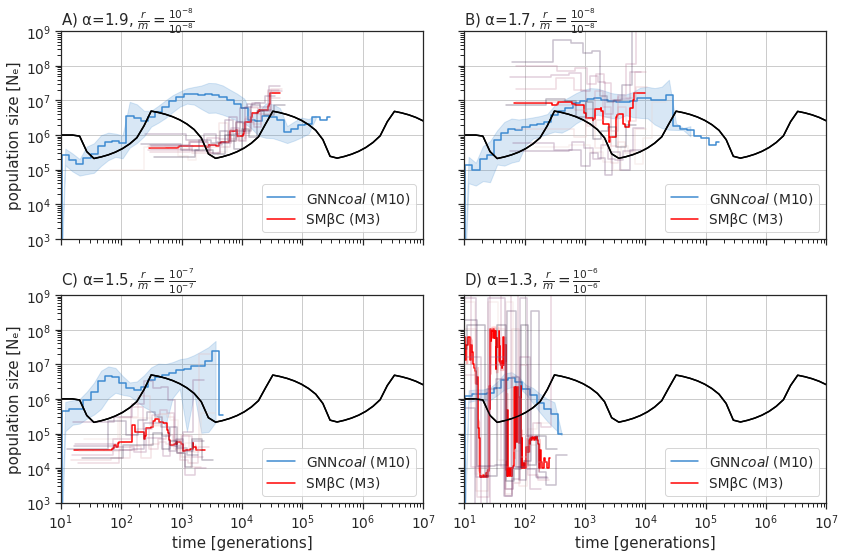

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-7}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-6}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")




for start_from, i, j in zip([0, 10, 20, 30], [1, 1, 0, 0], [1, 0, 1, 0]):
    alphat = 0.35
    rolling_mean = 10
    
    x = "Table_1_M3_argweaver_test__Sawtooth_Tc_rho_1_.csv"
    y = "Table_1_M3_argweaver_test__Sawtooth_pop_rho_1_.csv"
    
    x = pd.read_csv(x).iloc[:,1:]
    y = pd.read_csv(y).iloc[:,1:]
    
    x = x[start_from:start_from+10]
    y = y[start_from:start_from+10]
    
    time = x.melt()["value"]
    population_size = y.melt()["value"]
    
    df = pd.DataFrame([time, population_size]).T
    df.columns = ["time", "population_size"]
    
    df["replicates"] = np.tile(range(10), 40)
    df = remove_first_segment(df)
    df["time_rm"] = df["time"].rolling(rolling_mean).median()
    df["population_size_rm"] = df["population_size"].rolling(rolling_mean).median()
    df["population_size_rstd"] = df["population_size"].rolling(rolling_mean).std()

    df0 = df
    df0["model"] = smbc_hue
    df01 = pd.concat([df0]) #df1
    df01 = df01.reset_index()

    ax = axs[i][j]
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
    sns.lineplot(x=population_time, y=demography, ax=ax, color="black")#.set_title("", loc="left") # title
    ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
    ax.legend(loc='lower right')
    ax.grid(True)


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth_rt1.pdf", dpi=600)

In [ ]:
pwd

'/media/kevinkorfmann/external-hd-0/laptop-backup-24022023-razor/projects2/GNNcoal-analysis'

/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/arglearn/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


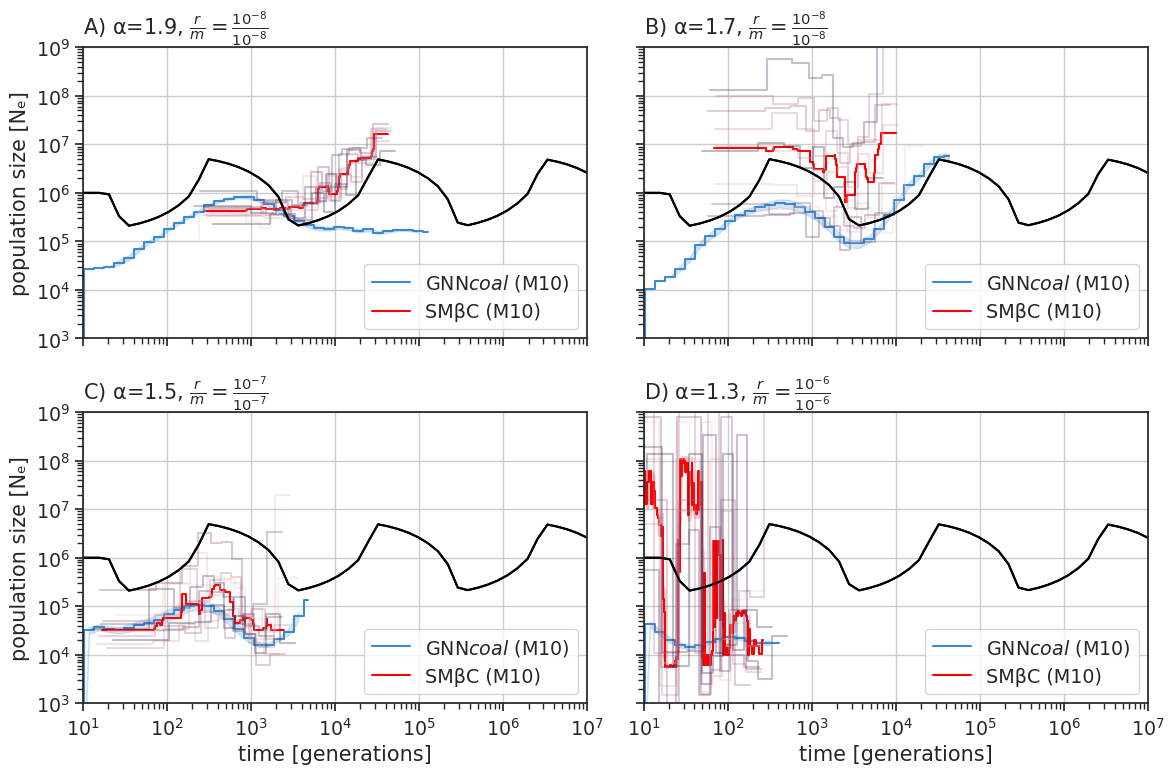

In [ ]:
sns.set(font_scale=1.25, style="ticks")
fig, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)


ax = axs[0][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_19
population_time_shorts_rep = population_time_shorts_rep_19
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"A) α=1.9, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)



ax = axs[0][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_17
population_time_shorts_rep = population_time_shorts_rep_17
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"B) α=1.7, $\frac{r}{m}=\frac{10^{-8}}{10^{-8}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][0]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_15
population_time_shorts_rep = population_time_shorts_rep_15
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"C) α=1.5, $\frac{r}{m}=\frac{10^{-7}}{10^{-7}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")
ax.grid(True)




ax = axs[1][1]
y_hat_shorts_rep_mcmc_means = []
population_time_shorts_rep_mcmc_means = []
y_hat_shorts_rep = y_hat_shorts_rep_13
population_time_shorts_rep = population_time_shorts_rep_13
for j in range(10):
    try:
        population_time_shorts_rep_mcmc_mean = np.mean(population_time_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_mean = np.mean(y_hat_shorts_rep[j], axis=0).tolist()
        y_hat_shorts_rep_mcmc_means += y_hat_shorts_rep_mcmc_mean
        population_time_shorts_rep_mcmc_means += population_time_shorts_rep_mcmc_mean
    except:
        pass
sns.lineplot(x=population_time_shorts_rep_mcmc_means, y=y_hat_shorts_rep_mcmc_means,  color="#3c89d0", drawstyle="steps-mid", ax=ax, label=gnn).set_title(r"D) α=1.3, $\frac{r}{m}=\frac{10^{-6}}{10^{-6}}$", loc="left")
sns.lineplot(x=population_time, y=demography, ax=ax, color="black")




for start_from, i, j in zip([0, 10, 20, 30], [1, 1, 0, 0], [1, 0, 1, 0]):
    alphat = 0.35
    rolling_mean = 10
    
    x = "./csvs/Table_1_M3_argweaver_test__Sawtooth_Tc_rho_1_.csv"
    y = "./csvs/Table_1_M3_argweaver_test__Sawtooth_pop_rho_1_.csv"
    
    x = pd.read_csv(x).iloc[:,1:]
    y = pd.read_csv(y).iloc[:,1:]
    
    x = x[start_from:start_from+10]
    y = y[start_from:start_from+10]
    
    time = x.melt()["value"]
    population_size = y.melt()["value"]
    
    df = pd.DataFrame([time, population_size]).T
    df.columns = ["time", "population_size"]
    
    df["replicates"] = np.tile(range(10), 40)
    df = remove_first_segment(df)
    df["time_rm"] = df["time"].rolling(rolling_mean).median()
    df["population_size_rm"] = df["population_size"].rolling(rolling_mean).median()
    df["population_size_rstd"] = df["population_size"].rolling(rolling_mean).std()

    df0 = df
    df0["model"] = smbc_hue
    df01 = pd.concat([df0]) #df1
    df01 = df01.reset_index()

    ax = axs[i][j]
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time_rm", y="population_size_rm", hue="model", drawstyle='steps-mid', ax=ax, palette=["red"])
    sns.lineplot(data=df01[df01["model"]==smbc_hue], x="time", y="population_size", hue="replicates", drawstyle='steps-mid',color="red", alpha=0.3, legend=False, ax=ax)
    sns.lineplot(x=population_time, y=demography, ax=ax, color="black")#.set_title("", loc="left") # title
    ax.set(xlabel="time [generations]", ylabel="population size [Nₑ]")
    ax.legend(loc='lower right')
    ax.grid(True)


ax.set_yscale("log")
ax.set_xscale("log")
ax.grid(True)
plt.ylim(1000, 1000_000_000)
plt.xlim(10,10_000_000)

plt.tight_layout()
plt.savefig("./figures/argweaver_sawtooth_rt1_fix.pdf", dpi=600)